# TABLES

In [2]:

import pandas as pd
import os
import sys
from os import path
from dotenv import load_dotenv

random_seed = 42
load_dotenv()
sys.path.append(path.dirname(os.getcwd()))

# Load the CSV file
file_path = "Results Analysis - Summary.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by="Model", key=lambda x: x.str.len())

df.replace("#DIV/0!", "-", inplace=True)


In [21]:
# Selecting relevant columns and renaming them for clarity
precision_recall_columns = ["Model", "Prompt", "True Class Precision", "True Class Recall"]
precision_recall_balanced_columns = ["Model", "Prompt", "Bal True Class Precision", "Bal True Class Recall"]
NEC_columns = ["Model", "Prompt", "NEC", "NEC reduce FN", "NEC reduce FP"]
NEC_balanced_columns = ["Model", "Prompt", "Bal NEC", "Bal NEC reduce FN", "Bal NEC reduce FP"]
NEC_realistic_columns = ["Model", "Prompt", "NEC realistic", "NEC reduce FN realistic", "NEC reduce FP realistic"]

precision_recall_caption = "Model performance: Precision and Recall."
precision_recall_balanced_caption = "Model performance: Precision and Recall in a balanced setting."
NEC_caption = "Model performance: NEC, NEC reducing FN, and NEC reducing FP."
NEC_balanced_caption = "Model performance: Balanced NEC, Balanced NEC reducing FN, and Balanced NEC reducing FP."
NEC_realistic_caption = "Model performance: Realistic NEC, Realistic NEC Reducing FN, and Realistic NEC Reducing FP."

columns_caption__format_items = [
    (precision_recall_columns, precision_recall_caption, "l l c c"),
    (precision_recall_balanced_columns, precision_recall_balanced_caption, "l l c c"),
    (NEC_columns, NEC_caption, "l l c c c"),
    (NEC_balanced_columns, NEC_balanced_caption, "l l c c c"),
    (NEC_realistic_columns, NEC_realistic_caption, "l l c c c")
]

for columns, caption, format in columns_caption__format_items:
    df_filtered = df[columns]

    # Generate LaTeX table using to_latex method
    latex_table = df_filtered.to_latex(index=False, column_format=format, caption=caption, float_format="%.3f", position="H")

    # Output the LaTeX table
    print(latex_table)

\begin{table}[H]
\caption{Model performance: Precision and Recall.}
\begin{tabular}{l l c c}
\toprule
Model & Prompt & True Class Precision & True Class Recall \\
\midrule
Always Positive & none & 0.357 & 1.000 \\
Always Negative & none & - & 0.000 \\
Roberta 3Epochs & none & 0.695 & 0.633 \\
ensemble-small-models & simple & 0.551 & 0.884 \\
ensemble-small-models & definition & 0.512 & 0.939 \\
google/gemma-1.1-7b-it & simple & 0.421 & 0.968 \\
google/gemma-1.1-7b-it & definition & 0.474 & 0.944 \\
meta-llama/Llama-3.1-8B-Instruct & simple & 0.559 & 0.859 \\
meta-llama/Llama-3.1-8B-Instruct & definition & 0.518 & 0.914 \\
meta-llama/Llama-3.3-70B-Instruct & simple & 0.567 & 0.920 \\
meta-llama/Llama-3.3-70B-Instruct & definition & 0.618 & 0.852 \\
mistralai/Mistral-7B-Instruct-v0.2 & simple & 0.645 & 0.674 \\
mistralai/Mistral-7B-Instruct-v0.2 & definition & 0.520 & 0.887 \\
meta-llama/Llama-3.2-11B-Vision-Instruct & definition & 0.396 & 0.949 \\
meta-llama/Llama-3.2-11B-Vision-Instruc

# Graphs

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
file_path = "Results Analysis - Summary.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by="Model", key=lambda x: x.str.len())

df.replace("#DIV/0!", -1, inplace=True)
df.fillna(-1, inplace=True)
df["True Class Precision"] = df["True Class Precision"].astype(float)
df["Bal True Class Precision"] = df["Bal True Class Precision"].astype(float)

light_red = "#ff9999"
medium_red = "#ff6666"
dark_red = "#cc0000"

light_blue = "#9999ff"
dark_blue = "#0000cc"

light_green = "#98df8a"
dark_green = "#2ca02c"

no_pattern = None
diagonal_lines = "\\\\"

plt.rcParams.update({"font.size": 16})

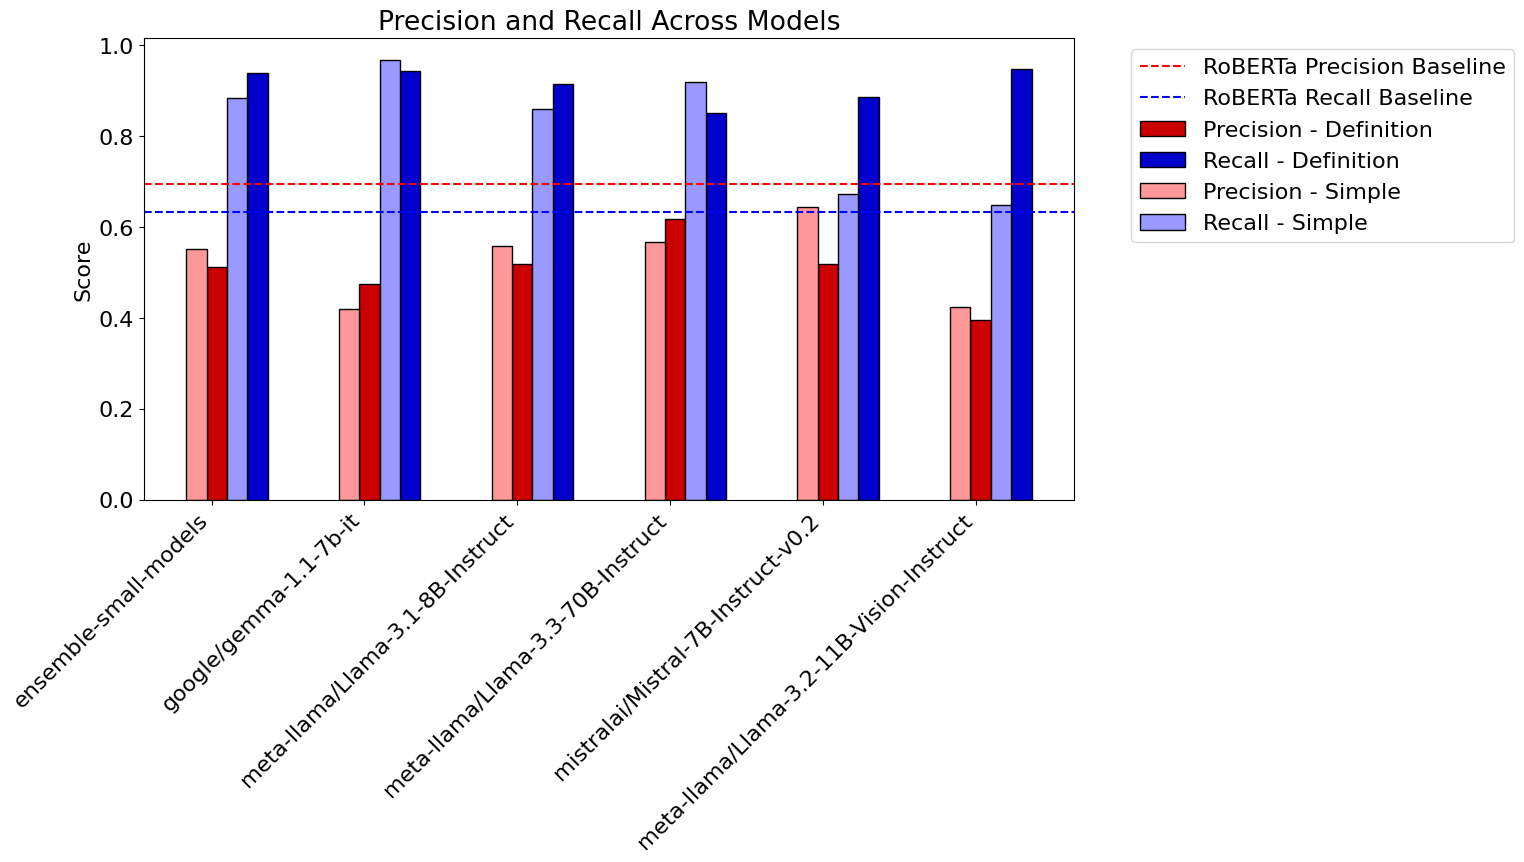

In [23]:
# Adjust bar positioning to include ensemble model without prompt while keeping correct order
fig, ax = plt.subplots(figsize=(12, 6))

metric_prompt_colors = {
    "Precision - Simple": (light_red, no_pattern),
    "Recall - Simple": (light_blue, no_pattern),
    "Precision - Definition": (dark_red, no_pattern),
    "Recall - Definition": (dark_blue, no_pattern),
    "Precision - Simple Balanced": (light_red, diagonal_lines),
    "Recall - Simple Balanced": (light_blue, diagonal_lines),
    "Precision - Definition Balanced": (dark_red, diagonal_lines),
    "Recall - Definition Balanced": (dark_blue, diagonal_lines),
}

# Filter out baseline models
df_filtered = df[~df["Model"].isin(["Always Positive", "Always Negative", "Mean Predictor"])].copy()
grouped = df_filtered.groupby(["Model", "Prompt"]).mean(numeric_only=True).reset_index()
unique_models = grouped["Model"].unique()
unique_models = unique_models[np.argsort([len(s) for s in unique_models])]


# Compute RoBERTa baseline values
roberta_baseline = df_filtered[df_filtered["Model"].str.contains("roberta", case=False)]
precision_baseline = roberta_baseline["True Class Precision"].mean()
recall_baseline = roberta_baseline["True Class Recall"].mean()

# X positions for each model (excluding RoBERTa)
x_positions = {}
offset = 0
bar_width = 0.4  # Standard width for clear separation

for model in unique_models:
    if "roberta" in model.lower():
        continue  # Skip plotting RoBERTa's bars
    x_positions[model] = offset
    offset += 3  # Ensure enough spacing between models

# Create bars with specific colors and spacing in the correct order
plotted_labels = set()  # Track labels to avoid duplicates in legend

for (model, prompt), subset in grouped.groupby(["Model", "Prompt"]):
    if "roberta" in model.lower():
        continue  # Skip plotting RoBERTa's bars
    
    x_base = x_positions[model]

    # Ensure correct order: Precision Simple, Precision Definition, Recall Simple, Recall Definition
    if prompt == "simple":
        x_prec = x_base
        x_rec = x_base + 2 * bar_width
    elif prompt == "definition":
        x_prec = x_base + bar_width
        x_rec = x_base + 3 * bar_width
    elif pd.isna(prompt) or prompt == "none":  # Handle ensemble model without prompt
        x_prec = x_base + 0.5 * bar_width  # Slightly shift to align well
        x_rec = x_base + 2.5 * bar_width
    else:
        continue  # Skip unexpected prompt types

    prec_label = f"Precision - {prompt.capitalize() if prompt != 'none' else 'Simple'}" 
    rec_label = f"Recall - {prompt.capitalize() if prompt != 'none' else 'Simple'}"

    # Only add labels once to avoid duplicates in the legend
    ax.bar(
        x_prec,
        subset["True Class Precision"].values[0],
        width=bar_width, 
        color=metric_prompt_colors.get(prec_label, light_red),  
        label=prec_label if prec_label not in plotted_labels else None,
        edgecolor="black",
        )
    ax.bar(
        x_rec, 
        subset["True Class Recall"].values[0],
        width=bar_width, 
        color=metric_prompt_colors.get(rec_label, light_blue),  
        label=rec_label if rec_label not in plotted_labels else None,
        edgecolor="black",
        )
    
    plotted_labels.add(prec_label)
    plotted_labels.add(rec_label)

# Add horizontal lines for RoBERTa model
ax.axhline(precision_baseline, linestyle="dashed", color="red", label="RoBERTa Precision Baseline")
ax.axhline(recall_baseline, linestyle="dashed", color="blue", label="RoBERTa Recall Baseline")

# Labels and legend
ax.set_xticks([x + 0.3 for x in x_positions.values()])
ax.set_xticklabels([model for model in unique_models if "roberta" not in model.lower()], rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Precision and Recall Across Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.savefig("precision_recall.svg", bbox_inches="tight")
plt.show()


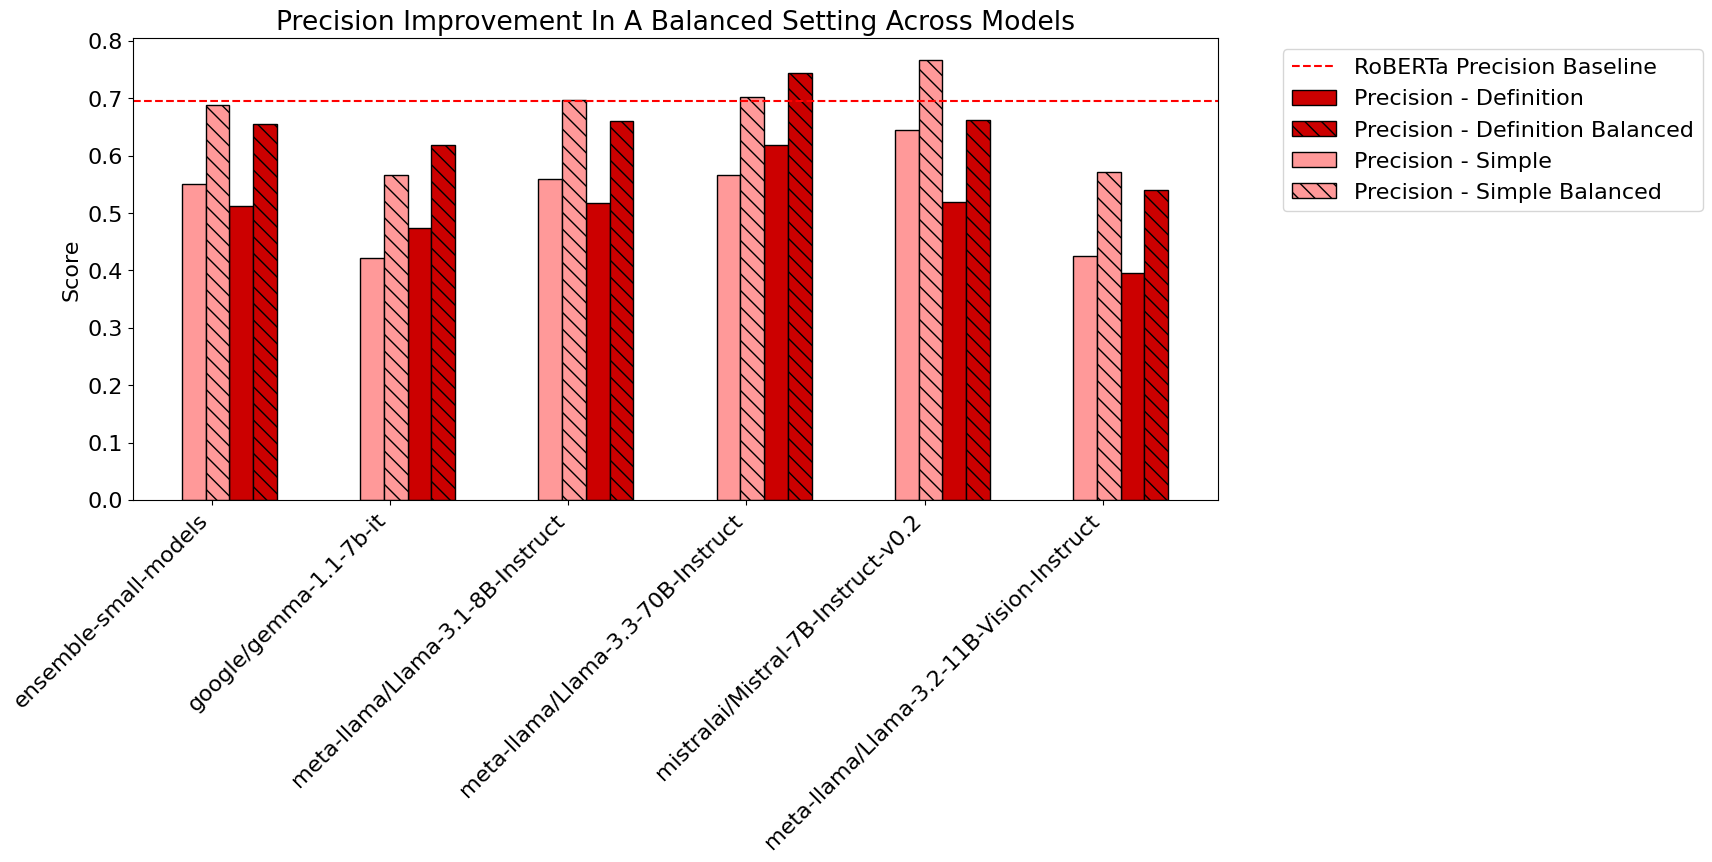

In [24]:
# Update color mapping to handle "none" prompt properly
metric_prompt_colors = {
    "Precision - Simple": (light_red, no_pattern),  
    "Precision - Simple Balanced": (light_red, diagonal_lines),
    "Precision - Definition": (dark_red, no_pattern), 
    "Precision - Definition Balanced": (dark_red, diagonal_lines),
}

# Filter out baseline models
df_filtered = df[~df["Model"].isin(["Always Positive", "Always Negative", "Mean Predictor"])].copy()
grouped = df_filtered.groupby(["Model", "Prompt"]).mean(numeric_only=True).reset_index()
unique_models = grouped["Model"].unique()
unique_models = unique_models[np.argsort([len(s) for s in unique_models])]

# Compute RoBERTa baseline values
roberta_baseline = df_filtered[df_filtered["Model"].str.contains("roberta", case=False)]
precision_baseline = roberta_baseline["True Class Precision"].mean()

# Re-run the plotting
fig, ax = plt.subplots(figsize=(14, 6))

# Create bars
plotted_labels = set()
for (model, prompt), subset in grouped.groupby(["Model", "Prompt"]):
    if "roberta" in model.lower():
        continue
    x_base = x_positions[model]
    
    if prompt == "simple":
        x_prec = x_base
        x_prec_bal = x_base + bar_width
    elif prompt == "definition":
        x_prec = x_base + 2 * bar_width
        x_prec_bal = x_base + 3 * bar_width
    elif prompt == "none":
        x_prec = x_base + bar_width
        x_prec_bal = x_base + 2 * bar_width
    else:
        continue
    
    prec_label = f"Precision - {prompt.capitalize() if prompt != 'none' else 'Simple'}"
    prec_bal_label = f"Precision - {prompt.capitalize() if prompt != 'none' else 'Simple'} Balanced"
    
    color, pattern = metric_prompt_colors[prec_label]
    color_bal, pattern_bal = metric_prompt_colors[prec_bal_label]

    ax.bar(x_prec,
           subset["True Class Precision"].values[0],
           width=bar_width, 
           color=color,
           hatch=pattern,
           label=prec_label if prec_label not in plotted_labels else None,
           edgecolor="black",
           )
    ax.bar(x_prec_bal,
           subset["Bal True Class Precision"].values[0],
           width=bar_width, 
           color=color_bal,
           hatch=pattern_bal, 
           label=prec_bal_label if prec_bal_label not in plotted_labels else None,
           edgecolor="black",
           )
    
    plotted_labels.update([prec_label, prec_bal_label])

# Add horizontal line for RoBERTa baseline
ax.axhline(precision_baseline, linestyle="dashed", color="red", label="RoBERTa Precision Baseline")

# Labels and legend
ax.set_xticks([x + 0.3 for x in x_positions.values()])
ax.set_xticklabels([model for model in unique_models if "roberta" not in model.lower()], rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Precision Improvement In A Balanced Setting Across Models")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.savefig("precision_recall_balanced.svg", bbox_inches="tight")
plt.show()

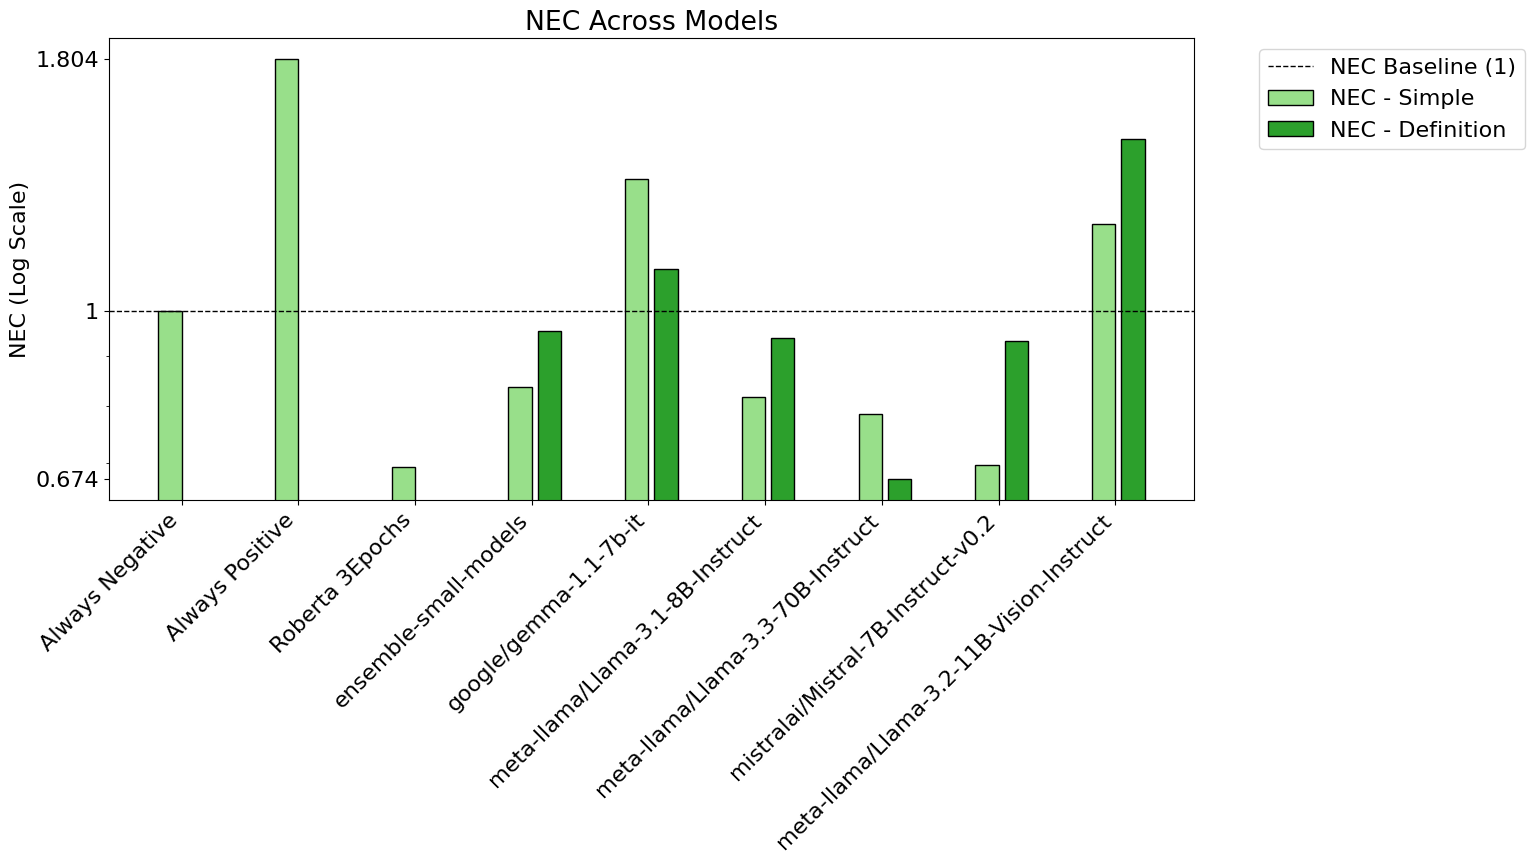

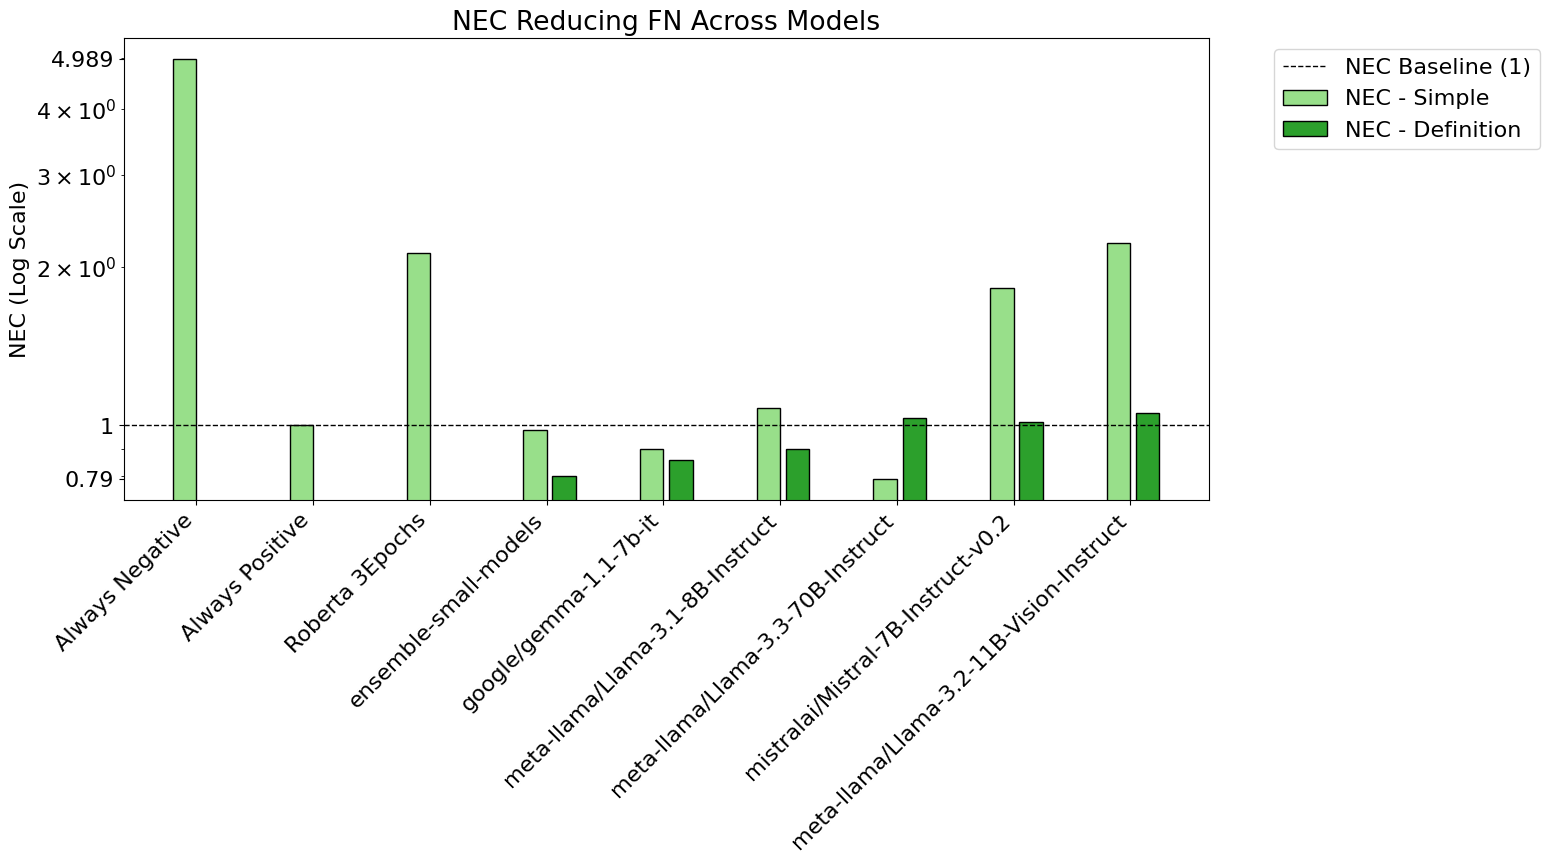

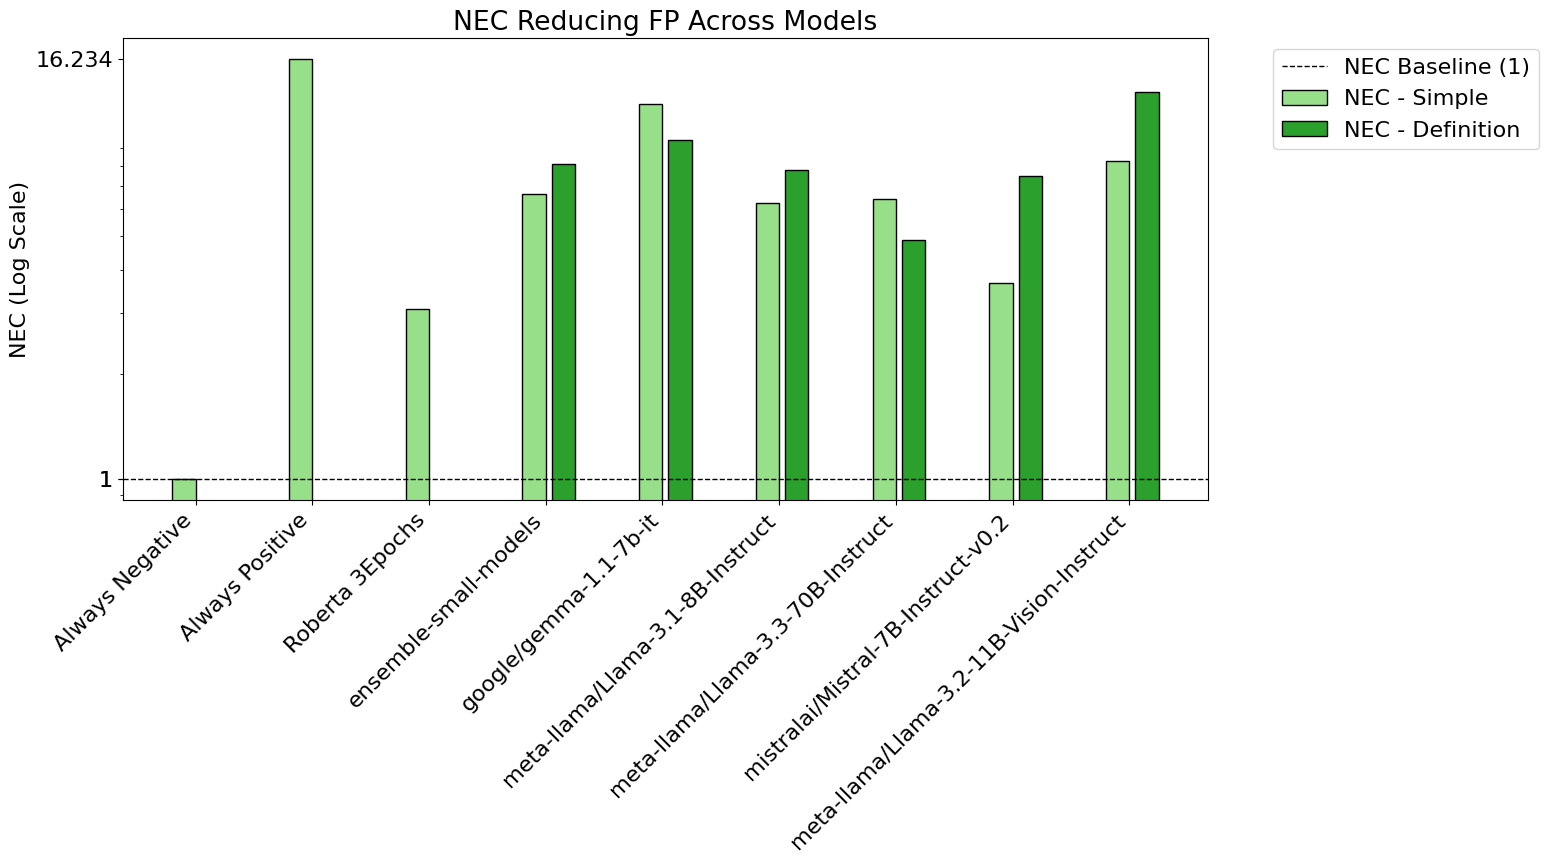

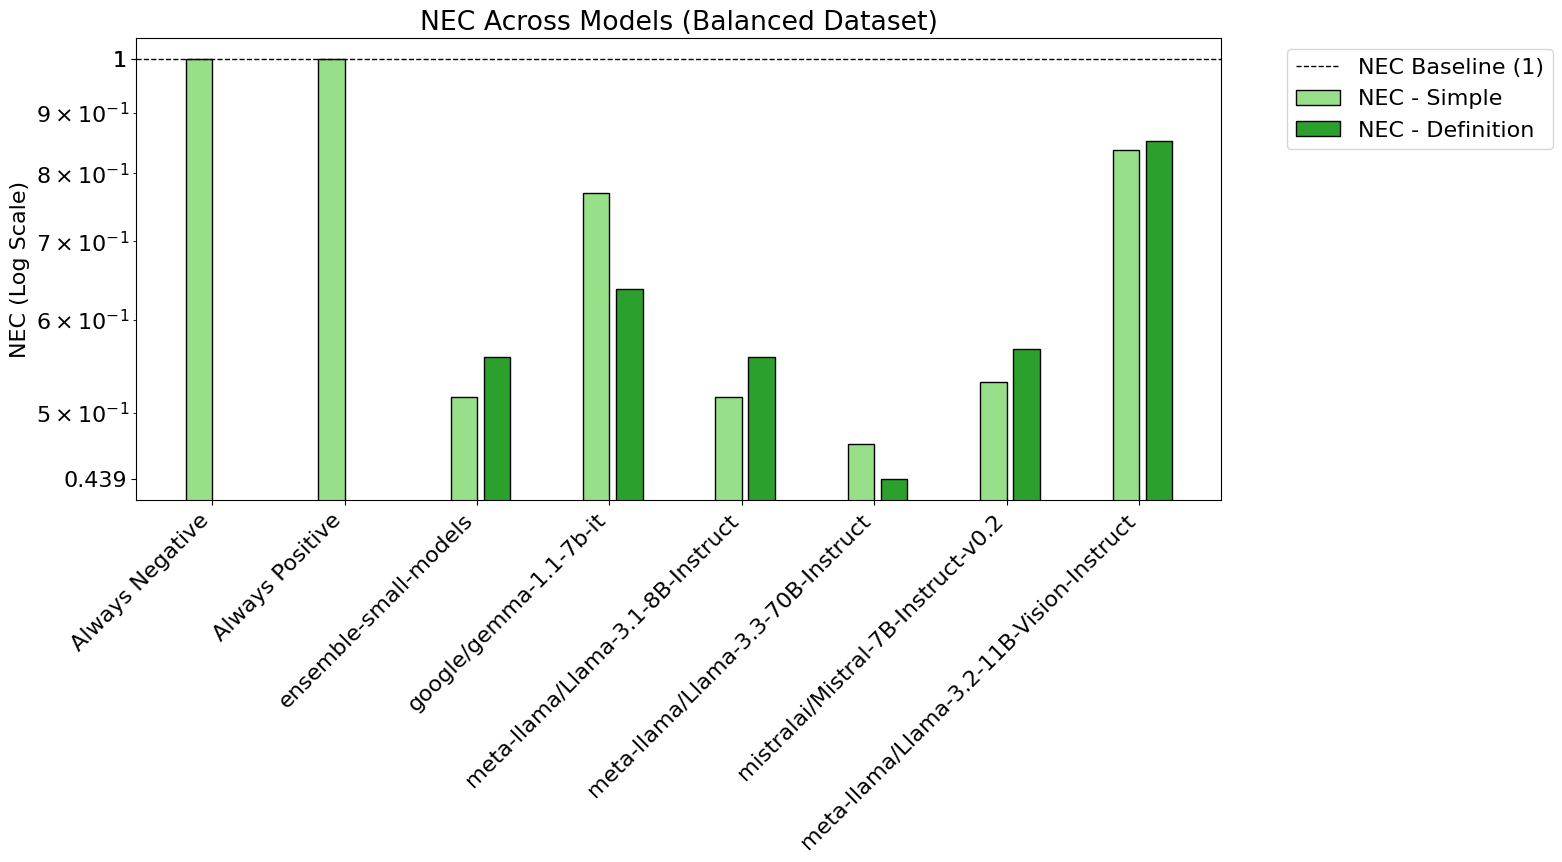

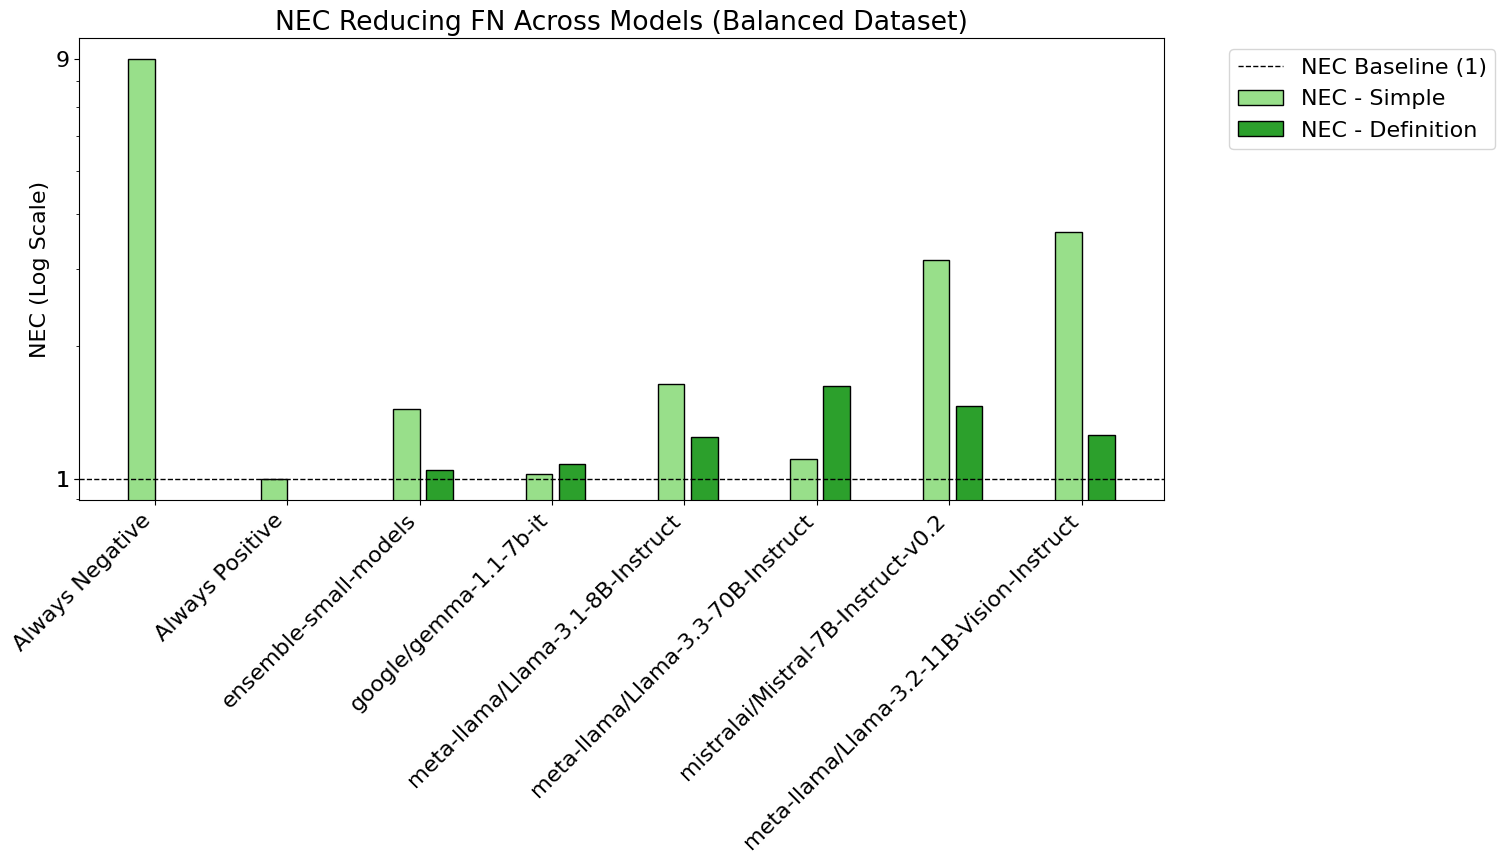

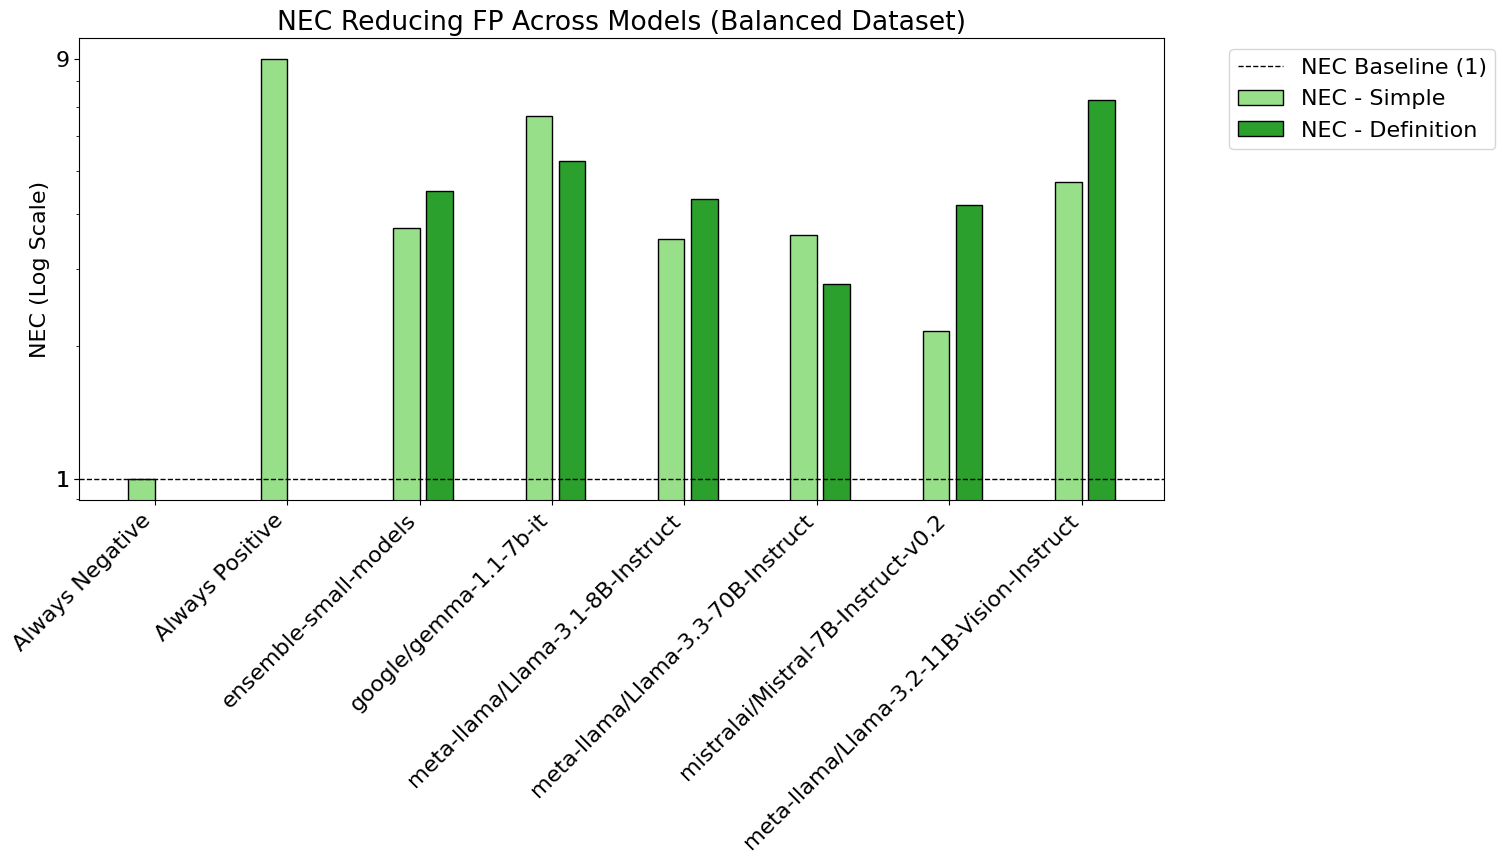

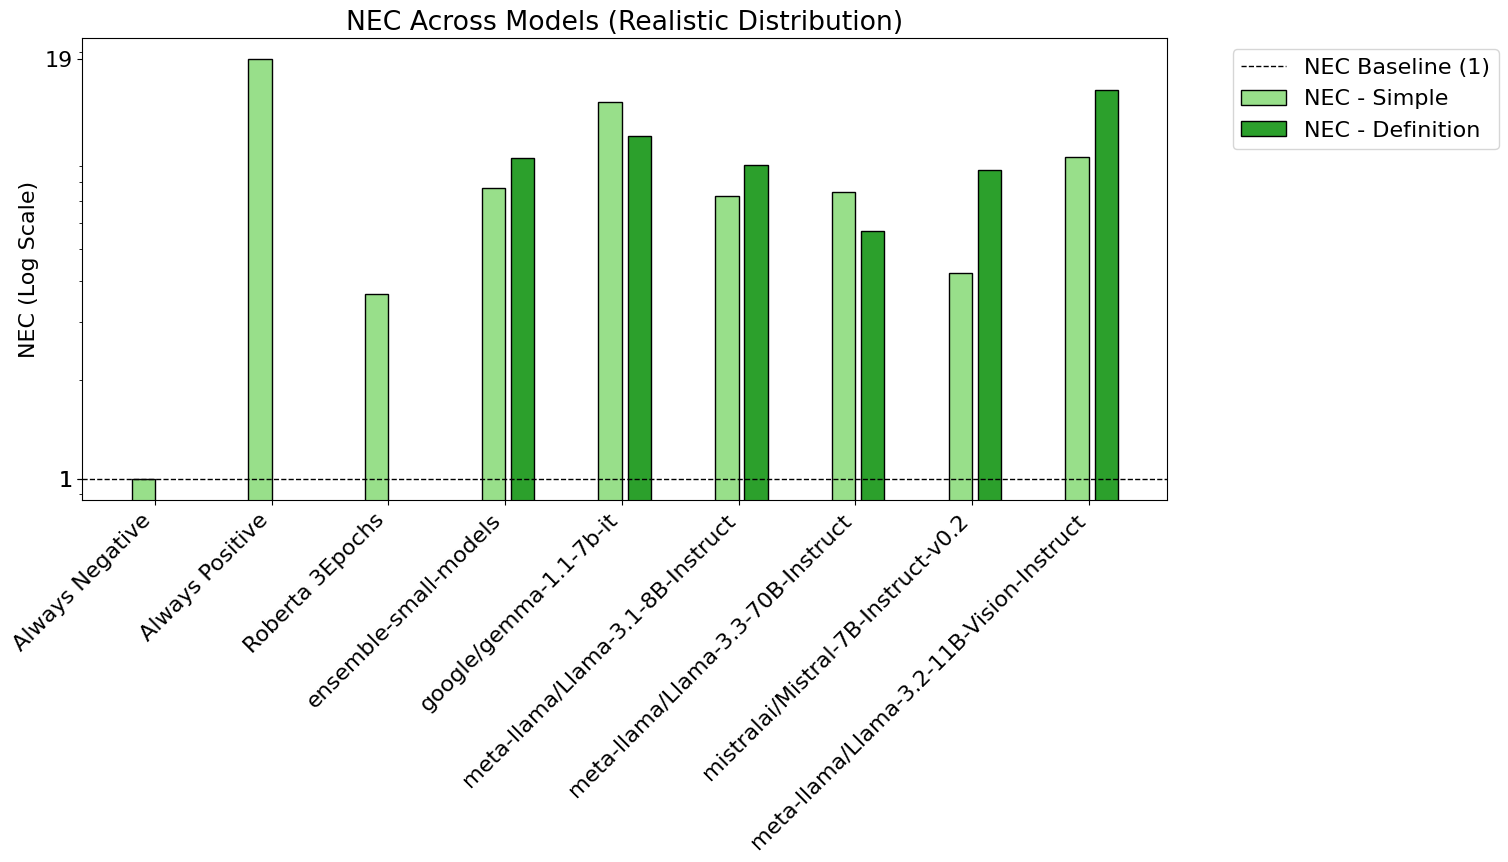

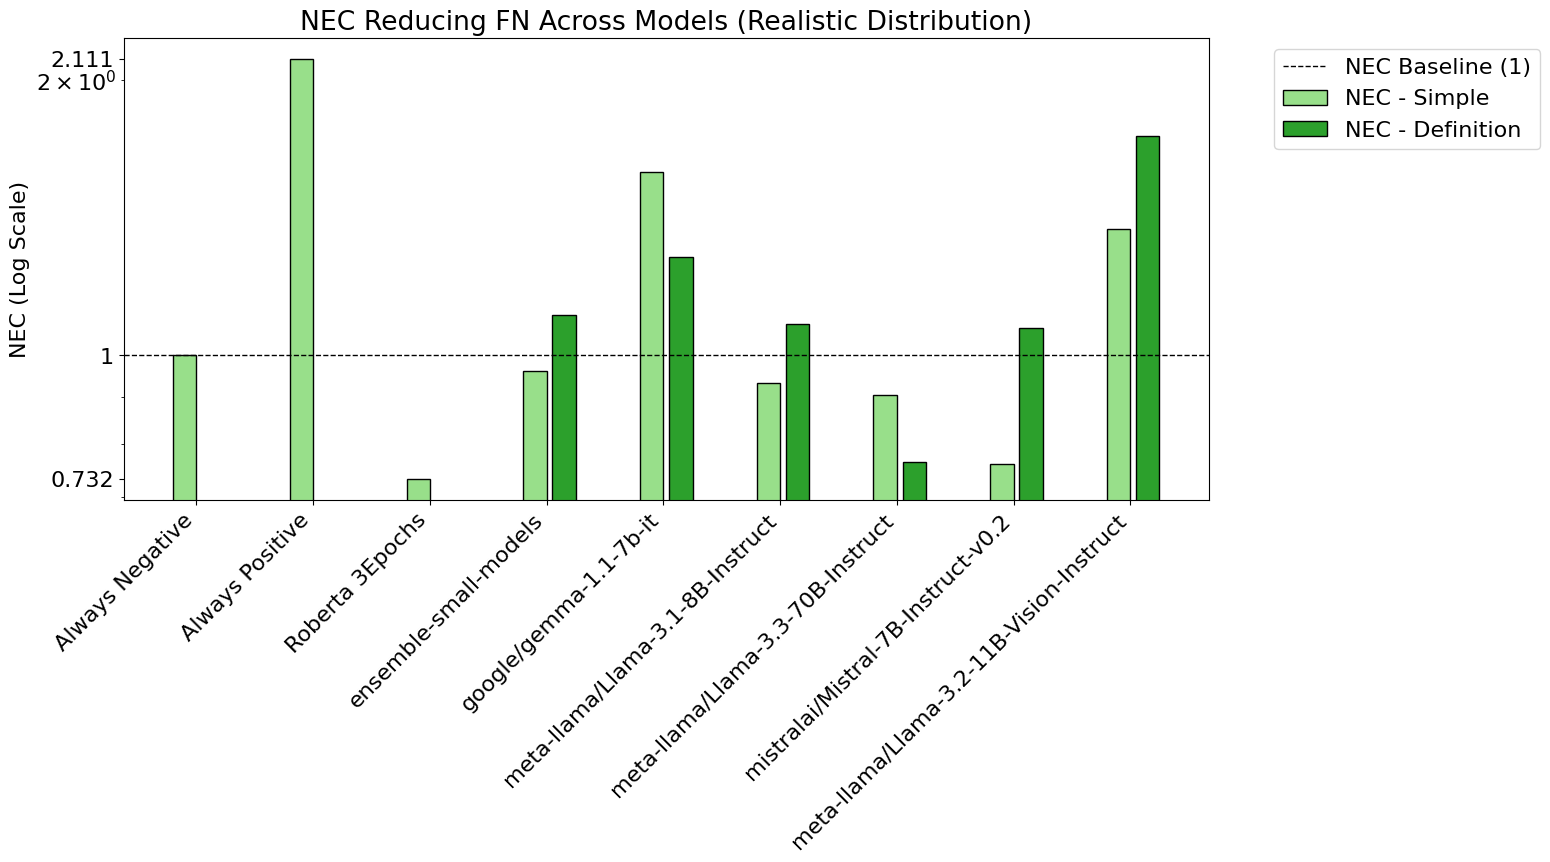

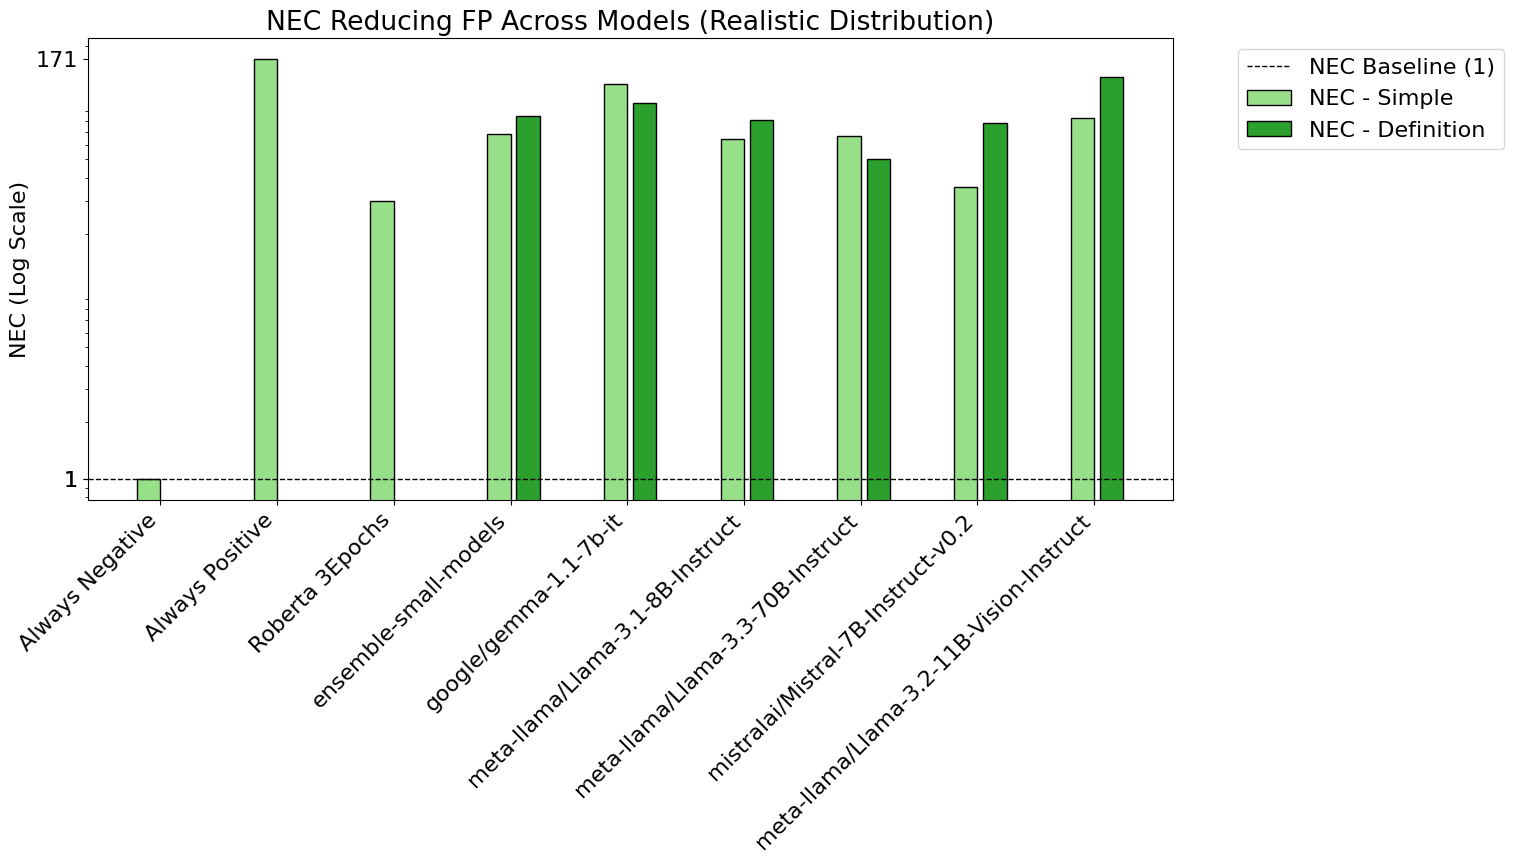

In [25]:
def show_nec_graph(nec_metric: str, nice_name: str, title: str, models_to_exclude: list[str] = ["Mean Predictor"]) -> None:
    # Filter out baseline models
    df_filtered = df[~df["Model"].isin(models_to_exclude)].copy()
    grouped = df_filtered.groupby(["Model", "Prompt"]).mean(numeric_only=True).reset_index()
    unique_models = grouped["Model"].unique()
    unique_models = unique_models[np.argsort([len(s) for s in unique_models])]

    # Define colors
    metric_colors = {
        "Simple": light_green, 
        "Definition": dark_green,
    }

    # Plot histogram with log scale
    fig, ax = plt.subplots(figsize=(14, 6))

    # X positions for each model
    x_positions = {}
    offset = 0
    bar_width = 0.4  # Adjusted width

    for model in unique_models:
        x_positions[model] = offset
        offset += 2  # Spacing between models

    # Create bars
    plotted_labels = set()
    for (model, prompt), subset in grouped.groupby(["Model", "Prompt"]):
        x_base = x_positions[model]
        
        if prompt == "definition":
            x_nec = x_base + 0.5
        else:
            x_nec = x_base
        
        nec_label = f"{nice_name} - {prompt.capitalize() if prompt != 'none' else 'Simple'}"
        
        ax.bar(
            x_nec,
            subset[nec_metric].values[0],
            width=bar_width, 
            color=metric_colors.get(prompt.capitalize(),
            light_green), 
            label=nec_label if nec_label not in plotted_labels else None,
            edgecolor="black",
            )
        
        plotted_labels.add(nec_label)

    # Add horizontal baseline at NEC = 1
    ax.axhline(1, linestyle="dashed", color="black", linewidth=1, label="NEC Baseline (1)")

    # Set log scale
    ax.set_yscale("log")
    ax.set_ylabel("NEC (Log Scale)")
    ax.set_xticks([x + 0.2 for x in x_positions.values()])
    ax.set_xticklabels([model for model in unique_models], rotation=45, ha="right")

    # Ensure y-axis labels appear
    # Ensure specific y-axis labels appear
    max_value = df_filtered[nec_metric].max()
    min_value = df_filtered[nec_metric].min()
    y_ticks = [min_value, 1, max_value]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels([f"{y:g}" for y in y_ticks])

    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.savefig(title + ".svg", bbox_inches="tight")
    plt.show()



show_nec_graph("NEC", "NEC", "NEC Across Models")
show_nec_graph("NEC reduce FN", "NEC", "NEC Reducing FN Across Models")
show_nec_graph("NEC reduce FP", "NEC", "NEC Reducing FP Across Models")

show_nec_graph("Bal NEC", "NEC", "NEC Across Models (Balanced Dataset)", models_to_exclude=["Mean Predictor", "Roberta 3Epochs"])
show_nec_graph("Bal NEC reduce FN", "NEC", "NEC Reducing FN Across Models (Balanced Dataset)", models_to_exclude=["Mean Predictor", "Roberta 3Epochs"])
show_nec_graph("Bal NEC reduce FP", "NEC", "NEC Reducing FP Across Models (Balanced Dataset)", models_to_exclude=["Mean Predictor", "Roberta 3Epochs"])

show_nec_graph("NEC realistic", "NEC", "NEC Across Models (Realistic Distribution)")
show_nec_graph("NEC reduce FN realistic", "NEC", "NEC Reducing FN Across Models (Realistic Distribution)")
show_nec_graph("NEC reduce FP realistic", "NEC", "NEC Reducing FP Across Models (Realistic Distribution)")

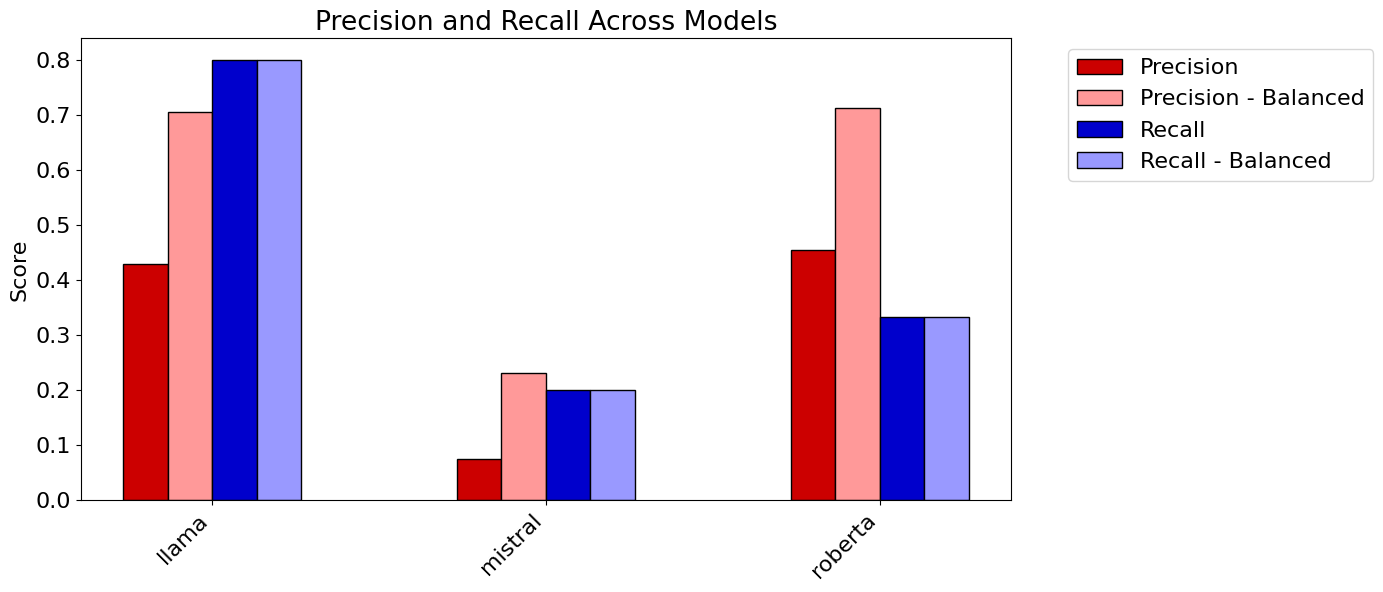

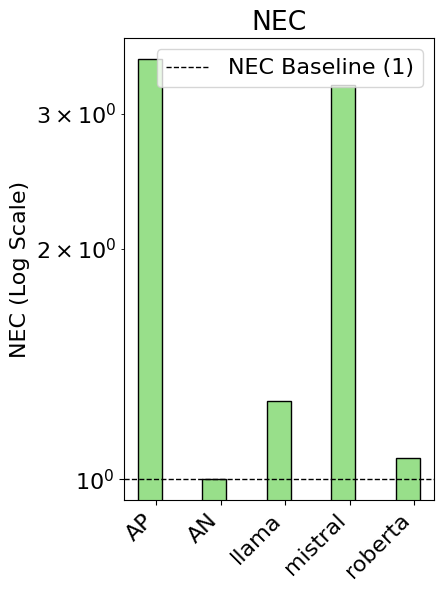

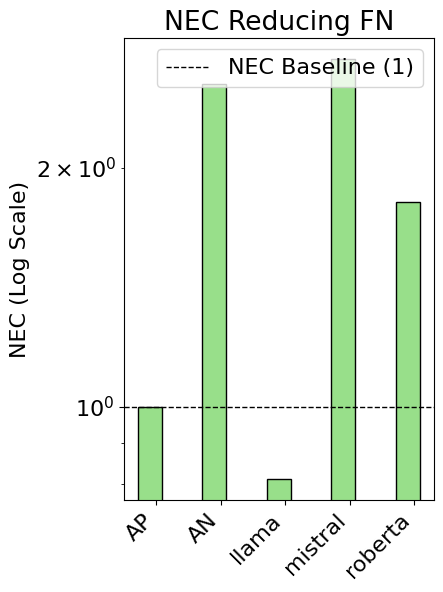

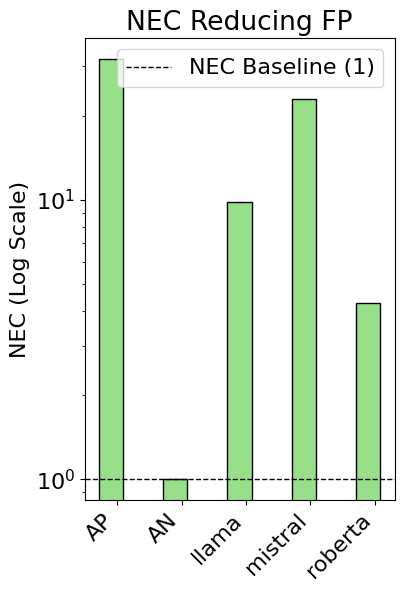

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the dataset
file_path = "ITW_Eval.csv"
df = pd.read_csv(file_path)
df = df.sort_values(by="Model", key=lambda x: x.str.len())

df.replace("#DIV/0!", -1, inplace=True)
df.fillna(-1, inplace=True)
df["Precision"] = df["Precision"].astype(float)
df["Precision.1"] = df["Precision.1"].astype(float)

light_red = "#ff9999"
medium_red = "#ff6666"
dark_red = "#cc0000"

light_blue = "#9999ff"
dark_blue = "#0000cc"

light_green = "#98df8a"
dark_green = "#2ca02c"

no_pattern = None
diagonal_lines = "\\\\"

plt.rcParams.update({"font.size": 16})

def plot_precision_recall(df):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    metric_prompt_colors = {
        "Precision": dark_red,
        "Recall": dark_blue,
        "Precision.1": light_red,
        "Recall.1": light_blue,
    }
    
    unique_models = ["llama", "mistral", "roberta"]
    x_positions = {model: i * 3 for i, model in enumerate(unique_models)}
    bar_width = 0.4
    
    for model in unique_models:
        subset = df[df["Model"] == model]
        x_base = x_positions[model]
        
        ax.bar(x_base, subset["Precision"].values[0], width=bar_width, color=metric_prompt_colors["Precision"], label="Precision" if model == unique_models[0] else None, edgecolor="black")
        ax.bar(x_base + bar_width, subset["Precision.1"].values[0], width=bar_width, color=metric_prompt_colors["Precision.1"], label="Precision - Balanced" if model == unique_models[0] else None, edgecolor="black")
        ax.bar(x_base + 2 * bar_width, subset["Recall"].values[0], width=bar_width, color=metric_prompt_colors["Recall"], label="Recall" if model == unique_models[0] else None, edgecolor="black")
        ax.bar(x_base + 3 * bar_width, subset["Recall.1"].values[0], width=bar_width, color=metric_prompt_colors["Recall.1"], label="Recall - Balanced" if model == unique_models[0] else None, edgecolor="black")
    
    ax.set_xticks([x + 1.5 * bar_width for x in x_positions.values()])
    ax.set_xticklabels(unique_models, rotation=45, ha="right")
    ax.set_ylabel("Score")
    ax.set_title("Precision and Recall Across Models")
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.savefig("precision_recall_itw.svg", bbox_inches="tight")
    plt.show()

def plot_nec(df, metric, title):
    fig, ax = plt.subplots(figsize=(4, 6))
    unique_models = df["Model"].unique()
    x_positions = {model: i * 2 for i, model in enumerate(unique_models)}
    bar_width = 0.75
    
    for model in unique_models:
        subset = df[df["Model"] == model]
        x_base = x_positions[model]
        ax.bar(x_base, subset[metric].values[0], width=bar_width, color=light_green, edgecolor="black")
    
    ax.axhline(1, linestyle="dashed", color="black", linewidth=1, label="NEC Baseline (1)")
    ax.set_yscale("log")
    ax.set_ylabel("NEC (Log Scale)")
    ax.set_xticks([x + 0.2 for x in x_positions.values()])
    ax.set_xticklabels(unique_models, rotation=45, ha="right")
    ax.set_title(title)
    ax.legend()
    
    plt.savefig(f"{title}_itw.svg", bbox_inches="tight")
    plt.show()

# Call functions to plot
plot_precision_recall(df)
plot_nec(df, "NEC", "NEC")
plot_nec(df, "NEC reduce FN", "NEC Reducing FN")
plot_nec(df, "Nec reduce FP", "NEC Reducing FP")


In [27]:
# Selecting relevant columns and renaming them for clarity
precision_recall_columns = ["Model", "Precision", "Recall"]
precision_recall_balanced_columns = ["Model", "Precision.1", "Recall.1"]
NEC_columns = ["Model", "NEC", "NEC reduce FN", "Nec reduce FP"]

precision_recall_caption = "Model performance: Precision and Recall."
precision_recall_balanced_caption = "Model performance: Precision and Recall in a balanced setting."
NEC_caption = "Model performance: NEC, NEC reducing FN, and NEC reducing FP."

columns_caption__format_items = [
    (precision_recall_columns, precision_recall_caption, "l l c c"),
    (precision_recall_balanced_columns, precision_recall_balanced_caption, "l l c c"),
    (NEC_columns, NEC_caption, "l l c c c"),
]

for columns, caption, format in columns_caption__format_items:
    df_filtered = df[columns]

    # Generate LaTeX table using to_latex method
    latex_table = df_filtered.to_latex(index=False, column_format=format, caption=caption, float_format="%.3f", position="H")

    # Output the LaTeX table
    print(latex_table)

\begin{table}[H]
\caption{Model performance: Precision and Recall.}
\begin{tabular}{l l c c}
\toprule
Model & Precision & Recall \\
\midrule
AP & 0.221 & 1.000 \\
AN & -1.000 & 0.000 \\
llama & 0.429 & 0.800 \\
mistral & 0.075 & 0.200 \\
roberta & 0.455 & 0.333 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Model performance: Precision and Recall in a balanced setting.}
\begin{tabular}{l l c c}
\toprule
Model & Precision.1 & Recall.1 \\
\midrule
AP & 0.500 & 1.000 \\
AN & -1.000 & 0.000 \\
llama & 0.706 & 0.800 \\
mistral & 0.231 & 0.200 \\
roberta & 0.714 & 0.333 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\caption{Model performance: NEC, NEC reducing FN, and NEC reducing FP.}
\begin{tabular}{l l c c c}
\toprule
Model & NEC & NEC reduce FN & Nec reduce FP \\
\midrule
AP & 3.533 & 1.000 & 31.800 \\
AN & 1.000 & 2.547 & 1.000 \\
llama & 1.267 & 0.811 & 9.800 \\
mistral & 3.267 & 2.736 & 23.000 \\
roberta & 1.067 & 1.811 & 4.267 \\
\bottomrule
\end{tab

In [3]:
from project.experiments.models import Experiment
import json
from project.models import YouTubeVideoInfo

with open("/home/leoli/Uni/Polimi/Thesis/master-thesis/data/youtube-common-10k/videos_infos.json", "r") as json_file:
    videos = [YouTubeVideoInfo.from_json(v) for v in json.load(json_file)]

import langdetect
from project.utils.subtitles_utils import text_from_subtitles

def detect_language(video: YouTubeVideoInfo) -> str | None:
    try:
        return langdetect.detect(video.description)
    except Exception as e:
        pass
    if video.subtitles:
        try: 
            return langdetect.detect(text_from_subtitles(video.subtitles))
        except Exception as e:
            pass
    if video.auto_subtitles:
        try:
            return langdetect.detect(text_from_subtitles(video.auto_subtitles))
        except Exception as e:
            pass
    try:
        return langdetect.detect(video.title)
    except Exception as e:
        return None


english_videos = [video for video in videos if detect_language(video) == "en"]

def get_labels_from_experiment(experiment_path, model_name) -> dict[str, dict | str]:
    with open(experiment_path, "r") as f:
        experiment = Experiment.from_json(json.load(f))
    return experiment.predicted_labels_by_model_and_video_id[model_name]

llama_labels = get_labels_from_experiment("/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1738877044.json", "meta-llama/Llama-3.3-70B-Instruct")
mistral_labels = get_labels_from_experiment("/home/leoli/Uni/Polimi/Thesis/master-thesis/notebooks/experiment-1738920290.json", "mistralai/Mistral-7B-Instruct-v0.2")
#roberta_labels = get_labels_from_experiment()



In [4]:
import pandas as pd

# Create lists to store the data
data_rows = []

for video in english_videos:
    llama_label = llama_labels.get(video.id, "error")
    mistral_label = mistral_labels.get(video.id, "error")

    # Make sure both models assigned a label to the video
    if not (isinstance(llama_label, dict) and isinstance(mistral_label, dict)):
        continue
    
    # If the models disagree on the label, skip the video
    if llama_label.get("is_conspiracy") != mistral_label.get("is_conspiracy"):
        continue
    
    # If we get here, the models agree, so we can use either label
    predicted_class = "conspiracy" if llama_label.get("is_conspiracy") else "non_conspiracy"
    
    # Add relevant metrics you want to plot
    data_rows.append({
        'predicted_class': predicted_class,
        'view_count': video.view_count,
        'like_count': video.like_count,
        'comment_count': video.comment_count,
        'duration_s': video.duration_s,
        "category": video.categories[0],
        "publish_date": video.publish_date,
    })

# Create DataFrame
df = pd.DataFrame(data_rows)



<Figure size 1000x600 with 0 Axes>

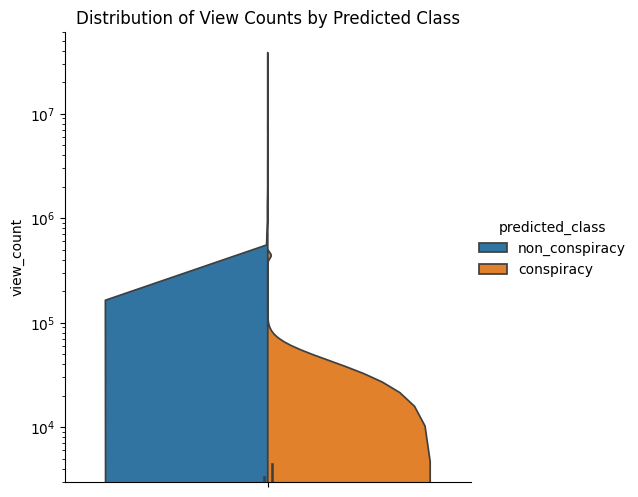

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.catplot(
    data=df, y="view_count", hue="predicted_class",
    kind="violin", split=True,
)
plt.title('Distribution of View Counts by Predicted Class')
plt.yscale('log')  # Optional: use log scale if the distribution is very skewed
plt.show()
    

/tmp/ipykernel_923168/3597655851.py:101: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time_dist = df.groupby(['predicted_class', pd.Grouper(key='publish_date', freq='Q')])['predicted_class'].count().unstack(0)


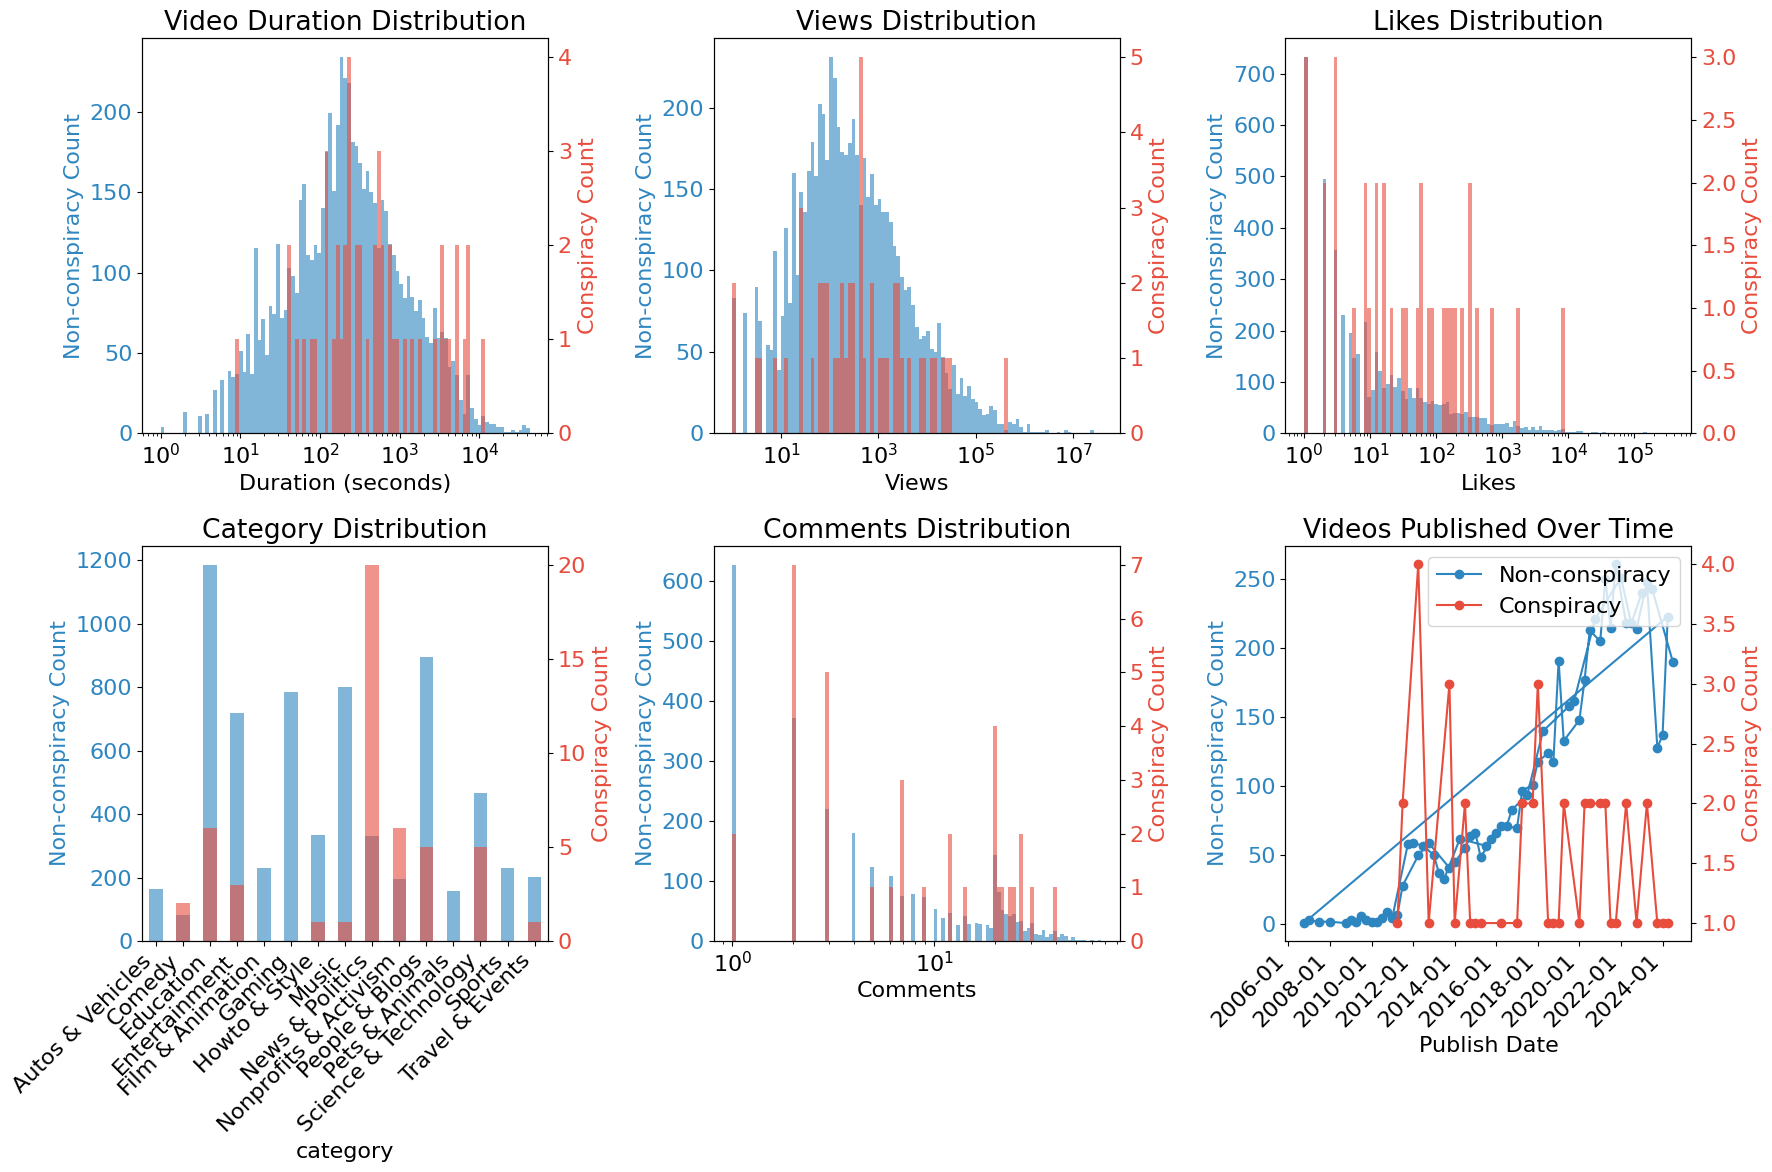


Class Distribution:
predicted_class
non_conspiracy    6782
conspiracy          50
Name: count, dtype: int64

Median values by class:
                 view_count  like_count  comment_count  duration_s
predicted_class                                                   
conspiracy            361.0        13.0            3.0       432.5
non_conspiracy        208.0         4.0            0.0       211.0


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns

plt.rcParams.update({"font.size": 16})

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Define colors for the two classes
non_conspiracy_color = "#2E86C1"  # blue
conspiracy_color = "#E74C3C"      # red

# Helper function for log bins
def log_bins(data, num_bins=100):
    min_val = max(min(data), 1)
    max_val = max(data)
    return np.logspace(np.log10(min_val), np.log10(max_val), num_bins)

# Helper function to create dual-axis histogram
def dual_axis_histogram(ax, data, bins, labels=['non_conspiracy', 'conspiracy']):
    ax2 = ax.twinx()  # Create second y-axis
    
    # Get data for each class
    non_conspiracy_data = data[data['predicted_class'] == labels[0]].iloc[:, 1]
    conspiracy_data = data[data['predicted_class'] == labels[1]].iloc[:, 1]
    
    # Plot non-conspiracy data on left y-axis
    n1, _, _ = ax.hist(non_conspiracy_data, 
                       bins=bins, alpha=0.6, color=non_conspiracy_color, 
                       label=labels[0])
    
    # Plot conspiracy data on right y-axis
    n2, _, _ = ax2.hist(conspiracy_data, 
                        bins=bins, alpha=0.6, color=conspiracy_color,
                        label=labels[1])
    
    # Set colors for y-axes
    ax.tick_params(axis='y', labelcolor=non_conspiracy_color)
    ax2.tick_params(axis='y', labelcolor=conspiracy_color)
    
    # Return maximum counts and the twin axes
    return max(n1), max(n2), ax2

# 1. Duration Distribution
data = df[['predicted_class', 'duration_s']]
bins = log_bins(data['duration_s'])
n1, n2, ax2 = dual_axis_histogram(axes[0, 0], data, bins)
axes[0, 0].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title("Video Duration Distribution")
axes[0, 0].set_xlabel("Duration (seconds)")

# 2. Views Distribution
data = df[['predicted_class', 'view_count']]
bins = log_bins(data['view_count'])
n1, n2, ax2 = dual_axis_histogram(axes[0, 1], data, bins)
axes[0, 1].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title("Views Distribution")
axes[0, 1].set_xlabel("Views")

# 3. Likes Distribution
data = df[['predicted_class', 'like_count']]
bins = log_bins(data['like_count'])
n1, n2, ax2 = dual_axis_histogram(axes[0, 2], data, bins)
axes[0, 2].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[0, 2].set_xscale('log')
axes[0, 2].set_title("Likes Distribution")
axes[0, 2].set_xlabel("Likes")

# 4. Category Distribution
category_by_class = df.groupby(['predicted_class', 'category']).size().unstack(fill_value=0)
ax2 = axes[1, 0].twinx()
category_by_class.loc['non_conspiracy'].plot(kind='bar', ax=axes[1, 0], color=non_conspiracy_color, alpha=0.6)
category_by_class.loc['conspiracy'].plot(kind='bar', ax=ax2, color=conspiracy_color, alpha=0.6)
axes[1, 0].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[1, 0].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)
axes[1, 0].set_title("Category Distribution")
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha="right")


# 5. Comments Distribution
data = df[['predicted_class', 'comment_count']]
bins = log_bins(data['comment_count'])
n1, n2, ax2 = dual_axis_histogram(axes[1, 1], data, bins)
axes[1, 1].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[1, 1].set_xscale('log')
axes[1, 1].set_title("Comments Distribution")
axes[1, 1].set_xlabel("Comments")

# 6. Time Distribution
df['publish_date'] = pd.to_datetime(df['publish_date'])
time_dist = df.groupby(['predicted_class', pd.Grouper(key='publish_date', freq='Q')])['predicted_class'].count().unstack(0)

ax2 = axes[1, 2].twinx()
time_dist['non_conspiracy'].plot(ax=axes[1, 2], color=non_conspiracy_color, marker='o')
time_dist['conspiracy'].plot(ax=ax2, color=conspiracy_color, marker='o')
axes[1, 2].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[1, 2].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)
axes[1, 2].set_title("Videos Published Over Time")
axes[1, 2].set_xlabel("Publish Date")
axes[1, 2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1, 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45)

# Add a common legend
lines1, labels1 = axes[1, 2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1, 2].legend(lines1 + lines2, ['Non-conspiracy', 'Conspiracy'], 
                 loc='upper right')

plt.tight_layout()
plt.savefig("class_distribution_analysis.svg", bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nClass Distribution:")
print(df['predicted_class'].value_counts())
print("\nMedian values by class:")
metrics = ['view_count', 'like_count', 'comment_count', 'duration_s']
print(df.groupby('predicted_class')[metrics].median())

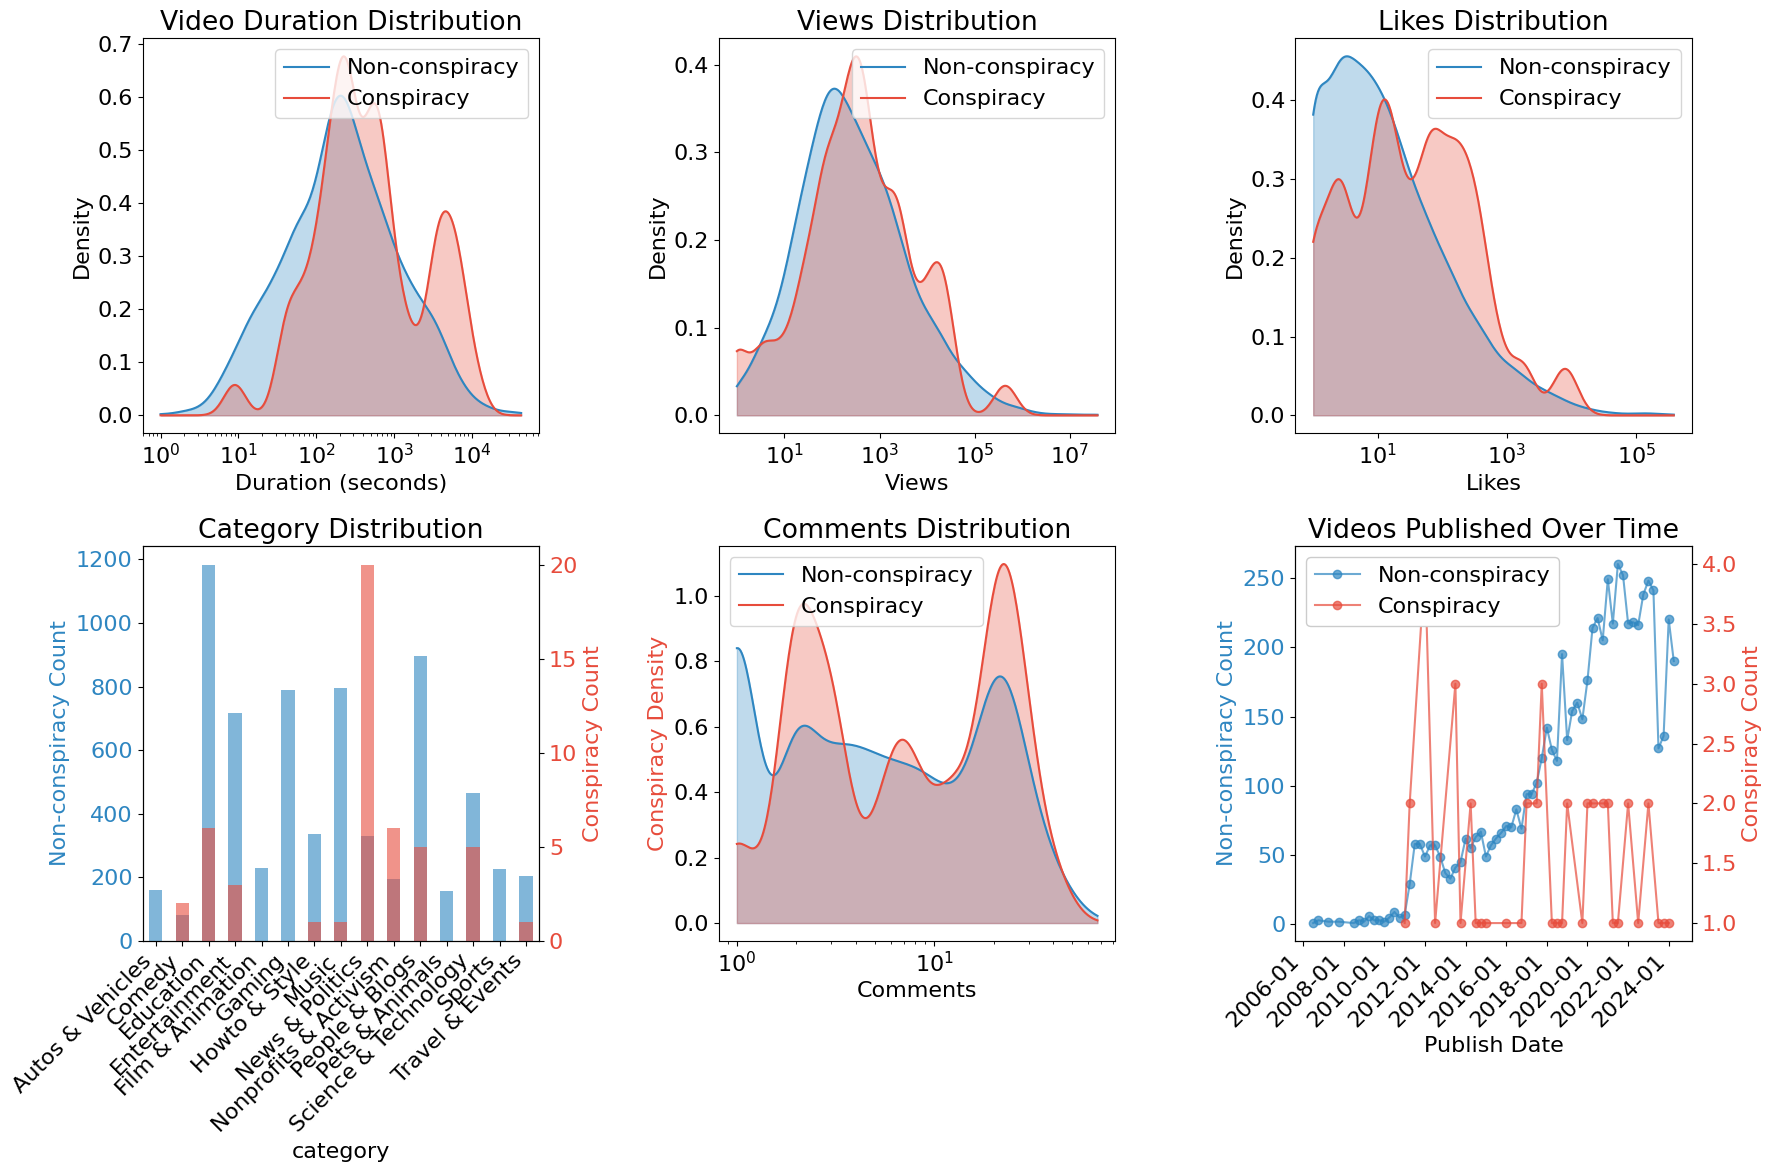


Class Distribution:
predicted_class
non_conspiracy    6772
conspiracy          50
Name: count, dtype: int64

Median values by class:
                 view_count  like_count  comment_count  duration_s
predicted_class                                                   
conspiracy            361.0        13.0            3.0       432.5
non_conspiracy        208.0         4.0            0.0       211.0


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

plt.rcParams.update({"font.size": 16})

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Define colors for the two classes
non_conspiracy_color = "#2E86C1"  # blue
conspiracy_color = "#E74C3C"      # red

# Helper function for log bins
def log_bins(data, num_bins=100):
    min_val = max(min(data), 1)
    max_val = max(data)
    return np.logspace(np.log10(min_val), np.log10(max_val), num_bins)

# Helper function to create dual-axis KDE plot
def dual_axis_kde(ax, data, labels=['non_conspiracy', 'conspiracy']):
    # Get data for each class and remove NaN/inf values
    non_conspiracy_data = data[data['predicted_class'] == labels[0]].iloc[:, 1]
    conspiracy_data = data[data['predicted_class'] == labels[1]].iloc[:, 1]
    
    # Clean data: remove NaN, inf, and zero values (for log scale)
    non_conspiracy_data = non_conspiracy_data[(non_conspiracy_data > 0) & np.isfinite(non_conspiracy_data)]
    conspiracy_data = conspiracy_data[(conspiracy_data > 0) & np.isfinite(conspiracy_data)]
    
    # Handle empty arrays
    if len(non_conspiracy_data) == 0 or len(conspiracy_data) == 0:
        print(f"Warning: Empty data after cleaning for one or both classes")
        return ax
    
    # Always use log scale for these metrics
    non_conspiracy_data = np.log10(non_conspiracy_data)
    conspiracy_data = np.log10(conspiracy_data)
    
    # Calculate KDE with adjusted bandwidth (smaller bandwidth for more detail)
    try:
        kde_nc = stats.gaussian_kde(non_conspiracy_data, bw_method=0.2)
        kde_c = stats.gaussian_kde(conspiracy_data, bw_method=0.2)
    except Exception as e:
        print(f"Warning: KDE calculation failed - {str(e)}")
        return ax
    
    # Create evaluation points with more points in dense regions
    x_min = min(non_conspiracy_data.min(), conspiracy_data.min())
    x_max = max(non_conspiracy_data.max(), conspiracy_data.max())
    x_eval = np.linspace(x_min, x_max, 300)
    
    # Plot KDEs
    nc_density = kde_nc(x_eval)
    c_density = kde_c(x_eval)
    
    # Convert x values back to original scale for plotting
    x_plot = 10**x_eval
    ax.set_xscale('log')
    
    # Plot both densities on the same axis
    ax.plot(x_plot, nc_density, color=non_conspiracy_color, label='Non-conspiracy')
    ax.fill_between(x_plot, nc_density, alpha=0.3, color=non_conspiracy_color)
    
    ax.plot(x_plot, c_density, color=conspiracy_color, label='Conspiracy')
    ax.fill_between(x_plot, c_density, alpha=0.3, color=conspiracy_color)
    
    # Add legend
    ax.legend()
    
    return ax

# 1. Duration Distribution
data = df[['predicted_class', 'duration_s']]
ax = dual_axis_kde(axes[0, 0], data)
axes[0, 0].set_ylabel('Density', color='black')
axes[0, 0].set_title("Video Duration Distribution")
axes[0, 0].set_xlabel("Duration (seconds)")
axes[0, 0].tick_params(axis='y', labelcolor='black')

# 2. Views Distribution
data = df[['predicted_class', 'view_count']]
ax = dual_axis_kde(axes[0, 1], data)
axes[0, 1].set_ylabel('Density', color='black')
axes[0, 1].set_title("Views Distribution")
axes[0, 1].set_xlabel("Views")
axes[0, 1].tick_params(axis='y', labelcolor='black')

# 3. Likes Distribution
data = df[['predicted_class', 'like_count']]
ax = dual_axis_kde(axes[0, 2], data)
axes[0, 2].set_ylabel('Density', color='black')
axes[0, 2].set_title("Likes Distribution")
axes[0, 2].set_xlabel("Likes")
axes[0, 2].tick_params(axis='y', labelcolor='black')

# 4. Category Distribution (unchanged)
category_by_class = df.groupby(['predicted_class', 'category']).size().unstack(fill_value=0)
ax2 = axes[1, 0].twinx()
category_by_class.loc['non_conspiracy'].plot(kind='bar', ax=axes[1, 0], color=non_conspiracy_color, alpha=0.6)
category_by_class.loc['conspiracy'].plot(kind='bar', ax=ax2, color=conspiracy_color, alpha=0.6)
axes[1, 0].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[1, 0].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)
axes[1, 0].set_title("Category Distribution")
plt.setp(axes[1, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 5. Comments Distribution
data = df[['predicted_class', 'comment_count']]
ax2 = dual_axis_kde(axes[1, 1], data)
axes[1, 1].set_ylabel('Non-conspiracy Density', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Density', color=conspiracy_color)
axes[1, 1].set_title("Comments Distribution")
axes[1, 1].set_xlabel("Comments")

# 6. Time Distribution
df['publish_date'] = pd.to_datetime(df['publish_date'])

# Create separate series for each class with quarterly aggregation
non_conspiracy_dates = df[df['predicted_class'] == 'non_conspiracy']['publish_date']
conspiracy_dates = df[df['predicted_class'] == 'conspiracy']['publish_date']

# Aggregate by quarter for each class
non_conspiracy_quarterly = non_conspiracy_dates.groupby(non_conspiracy_dates.dt.to_period('Q')).size()
conspiracy_quarterly = conspiracy_dates.groupby(conspiracy_dates.dt.to_period('Q')).size()

# Convert PeriodIndex to datetime for plotting
non_conspiracy_quarterly.index = non_conspiracy_quarterly.index.to_timestamp()
conspiracy_quarterly.index = conspiracy_quarterly.index.to_timestamp()

# Clear the existing axis
axes[1, 2].clear()

# Create twin axis
ax2 = axes[1, 2].twinx()

# Plot non-conspiracy on left axis
axes[1, 2].plot(non_conspiracy_quarterly.index, non_conspiracy_quarterly.values, 
                color=non_conspiracy_color, marker='o', linestyle='-', 
                label='Non-conspiracy', alpha=0.7)

# Plot conspiracy on right axis
ax2.plot(conspiracy_quarterly.index, conspiracy_quarterly.values, 
         color=conspiracy_color, marker='o', linestyle='-', 
         label='Conspiracy', alpha=0.7)

# Set labels and colors
axes[1, 2].set_title("Videos Published Over Time")
axes[1, 2].set_xlabel("Publish Date")
axes[1, 2].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)

# Set tick colors
axes[1, 2].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)

# Format x-axis
axes[1, 2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1, 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend by combining handles from both axes
lines1, labels1 = axes[1, 2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, ['Non-conspiracy', 'Conspiracy'], 
          loc='upper left', framealpha=1.0)

plt.tight_layout()
plt.savefig("class_distribution_analysis.svg", bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nClass Distribution:")
print(df['predicted_class'].value_counts())
print("\nMedian values by class:")
metrics = ['view_count', 'like_count', 'comment_count', 'duration_s']
print(df.groupby('predicted_class')[metrics].median())

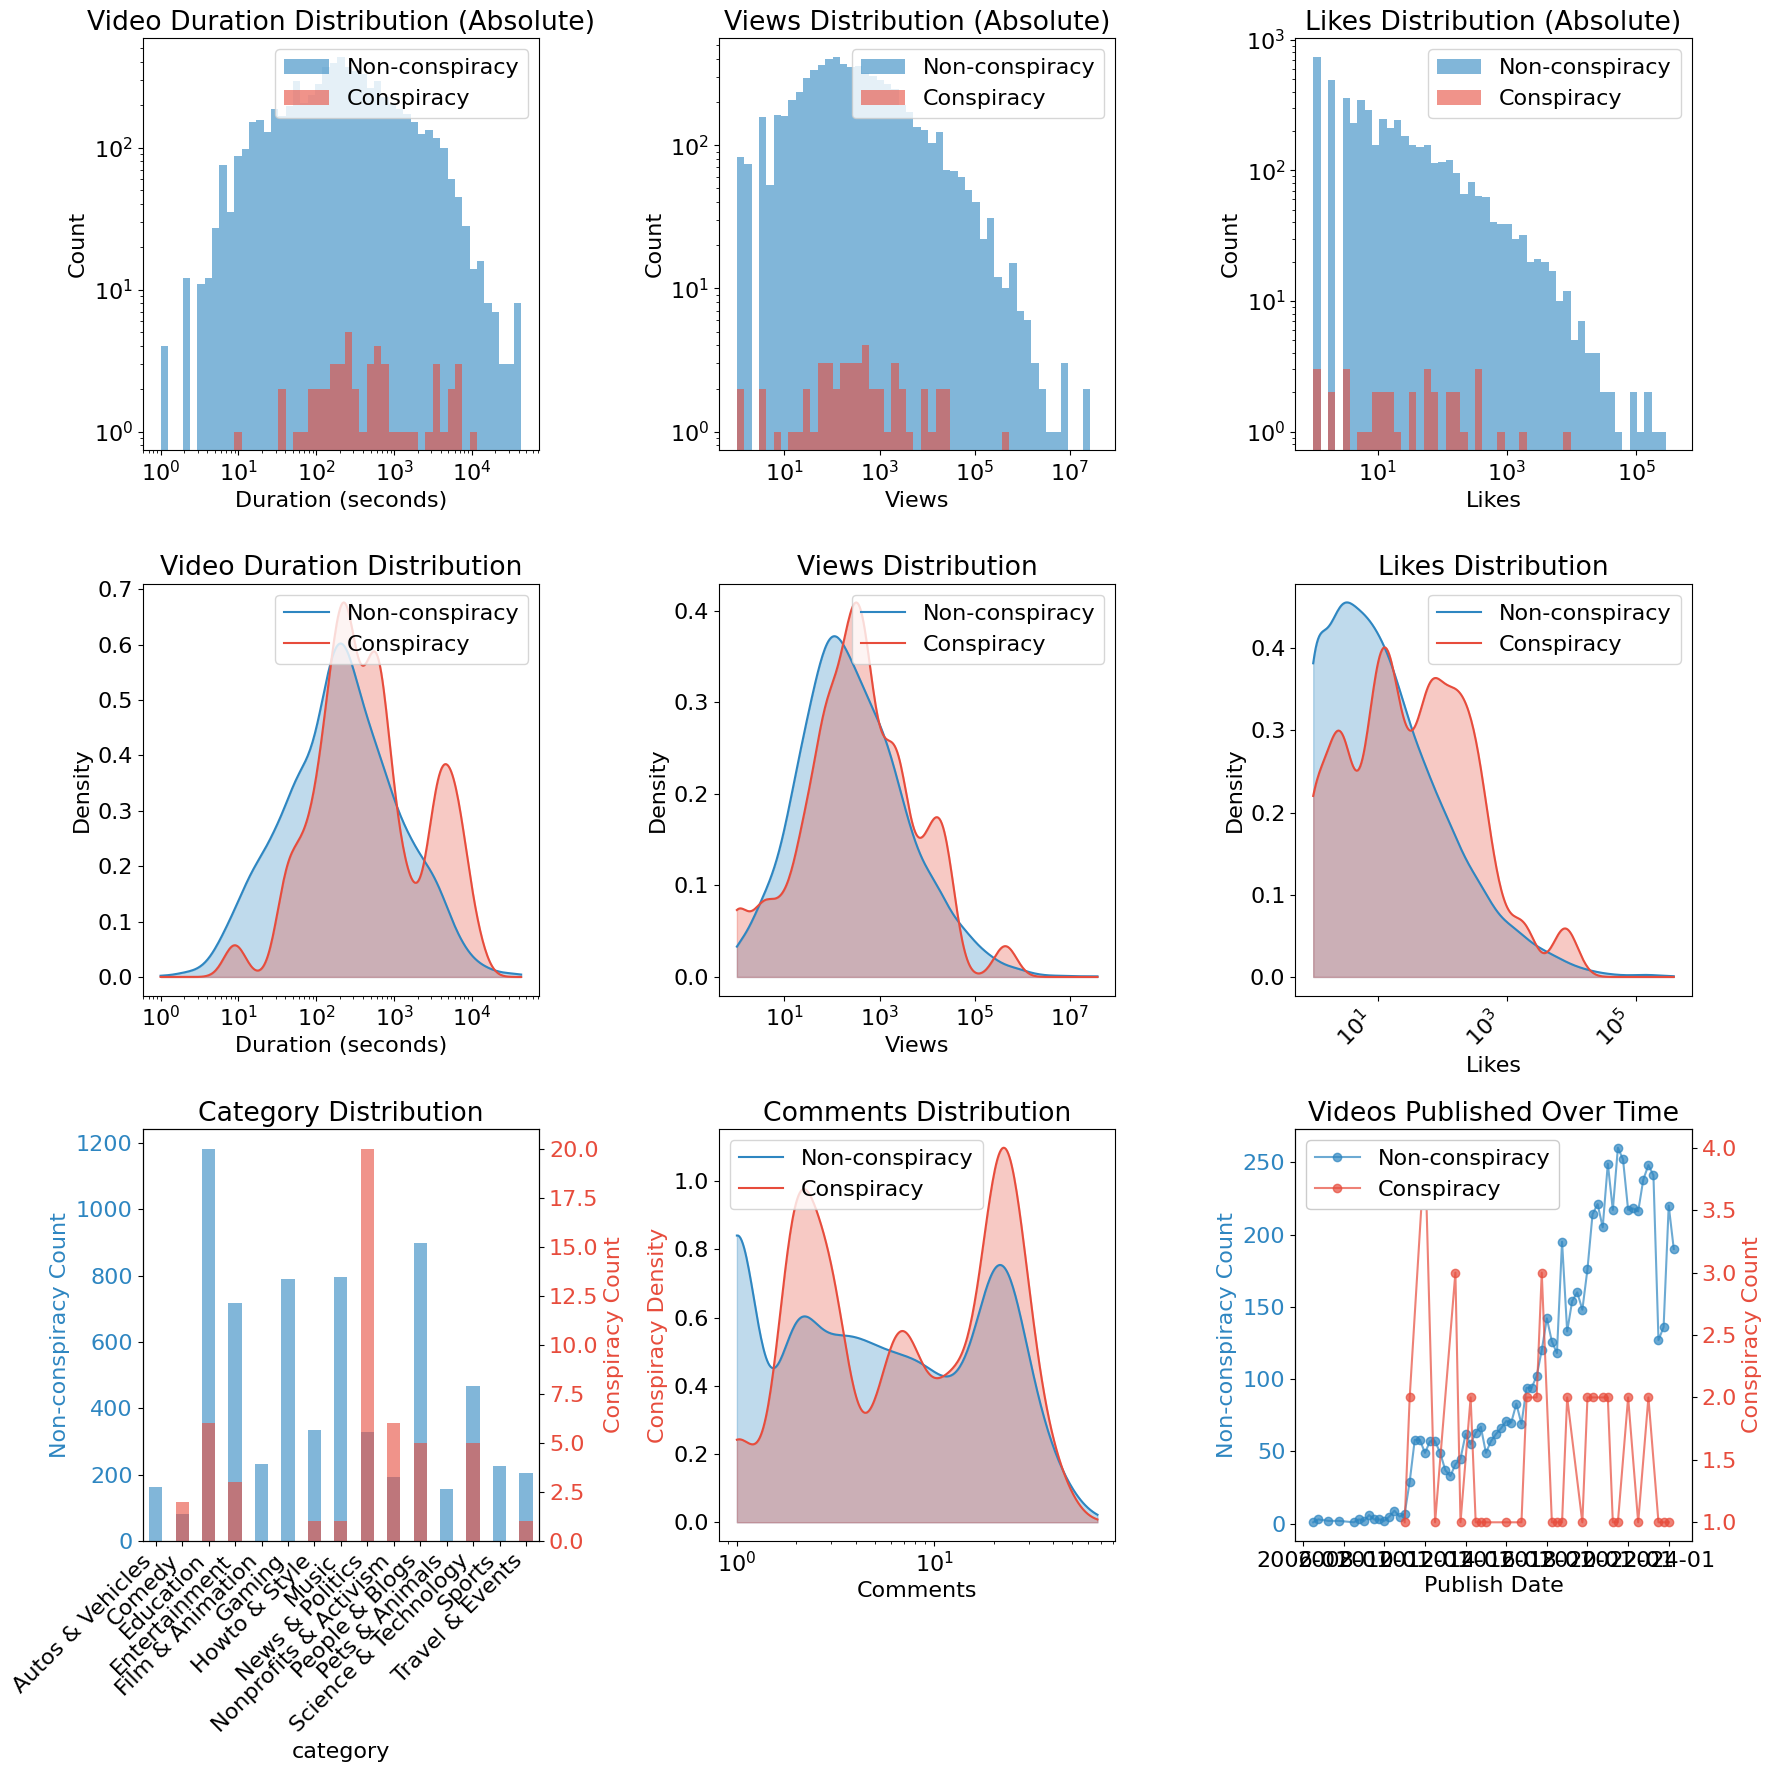


Class Distribution:
predicted_class
non_conspiracy    6772
conspiracy          50
Name: count, dtype: int64

Median values by class:
                 view_count  like_count  comment_count  duration_s
predicted_class                                                   
conspiracy            361.0        13.0            3.0       432.5
non_conspiracy        208.0         4.0            0.0       211.0


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

plt.rcParams.update({"font.size": 16})

# Create figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Define colors for the two classes
non_conspiracy_color = "#2E86C1"  # blue
conspiracy_color = "#E74C3C"      # red

# Helper function for log bins
def log_bins(data, num_bins=100):
    min_val = max(min(data), 1)
    max_val = max(data)
    return np.logspace(np.log10(min_val), np.log10(max_val), num_bins)

# Helper function to create dual-axis KDE plot
def dual_axis_kde(ax, data, labels=['non_conspiracy', 'conspiracy']):
    # Get data for each class and remove NaN/inf values
    non_conspiracy_data = data[data['predicted_class'] == labels[0]].iloc[:, 1]
    conspiracy_data = data[data['predicted_class'] == labels[1]].iloc[:, 1]
    
    # Clean data: remove NaN, inf, and zero values (for log scale)
    non_conspiracy_data = non_conspiracy_data[(non_conspiracy_data > 0) & np.isfinite(non_conspiracy_data)]
    conspiracy_data = conspiracy_data[(conspiracy_data > 0) & np.isfinite(conspiracy_data)]
    
    # Handle empty arrays
    if len(non_conspiracy_data) == 0 or len(conspiracy_data) == 0:
        print(f"Warning: Empty data after cleaning for one or both classes")
        return ax
    
    # Always use log scale for these metrics
    non_conspiracy_data = np.log10(non_conspiracy_data)
    conspiracy_data = np.log10(conspiracy_data)
    
    # Calculate KDE with adjusted bandwidth (smaller bandwidth for more detail)
    try:
        kde_nc = stats.gaussian_kde(non_conspiracy_data, bw_method=0.2)
        kde_c = stats.gaussian_kde(conspiracy_data, bw_method=0.2)
    except Exception as e:
        print(f"Warning: KDE calculation failed - {str(e)}")
        return ax
    
    # Create evaluation points with more points in dense regions
    x_min = min(non_conspiracy_data.min(), conspiracy_data.min())
    x_max = max(non_conspiracy_data.max(), conspiracy_data.max())
    x_eval = np.linspace(x_min, x_max, 300)
    
    # Plot KDEs
    nc_density = kde_nc(x_eval)
    c_density = kde_c(x_eval)
    
    # Convert x values back to original scale for plotting
    x_plot = 10**x_eval
    ax.set_xscale('log')
    
    # Plot both densities on the same axis
    ax.plot(x_plot, nc_density, color=non_conspiracy_color, label='Non-conspiracy')
    ax.fill_between(x_plot, nc_density, alpha=0.3, color=non_conspiracy_color)
    
    ax.plot(x_plot, c_density, color=conspiracy_color, label='Conspiracy')
    ax.fill_between(x_plot, c_density, alpha=0.3, color=conspiracy_color)
    
    # Add legend
    ax.legend()
    
    return ax

# Helper function for absolute value plots with log scale
def absolute_value_plot(ax, data, labels=['non_conspiracy', 'conspiracy']):
    # Get data for each class and remove NaN/inf values
    non_conspiracy_data = data[data['predicted_class'] == labels[0]].iloc[:, 1]
    conspiracy_data = data[data['predicted_class'] == labels[1]].iloc[:, 1]
    
    # Clean data: remove NaN, inf, and zero values
    non_conspiracy_data = non_conspiracy_data[(non_conspiracy_data > 0) & np.isfinite(non_conspiracy_data)]
    conspiracy_data = conspiracy_data[(conspiracy_data > 0) & np.isfinite(conspiracy_data)]
    
    # Create histogram with log scale
    bins = np.logspace(np.log10(min(non_conspiracy_data.min(), conspiracy_data.min())),
                      np.log10(max(non_conspiracy_data.max(), conspiracy_data.max())),
                      50)
    
    ax.hist(non_conspiracy_data, bins=bins, alpha=0.6, color=non_conspiracy_color, 
            label='Non-conspiracy')
    ax.hist(conspiracy_data, bins=bins, alpha=0.6, color=conspiracy_color,
            label='Conspiracy')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()
    
    return ax

# First row: Absolute value distributions (log scale)
# 1. Duration Distribution (Absolute)
data = df[['predicted_class', 'duration_s']]
ax = absolute_value_plot(axes[0, 0], data)
axes[0, 0].set_ylabel('Count', color='black')
axes[0, 0].set_title("Video Duration Distribution (Absolute)")
axes[0, 0].set_xlabel("Duration (seconds)")
axes[0, 0].tick_params(axis='y', labelcolor='black')

# 2. Views Distribution (Absolute)
data = df[['predicted_class', 'view_count']]
ax = absolute_value_plot(axes[0, 1], data)
axes[0, 1].set_ylabel('Count', color='black')
axes[0, 1].set_title("Views Distribution (Absolute)")
axes[0, 1].set_xlabel("Views")
axes[0, 1].tick_params(axis='y', labelcolor='black')

# 3. Likes Distribution (Absolute)
data = df[['predicted_class', 'like_count']]
ax = absolute_value_plot(axes[0, 2], data)
axes[0, 2].set_ylabel('Count', color='black')
axes[0, 2].set_title("Likes Distribution (Absolute)")
axes[0, 2].set_xlabel("Likes")
axes[0, 2].tick_params(axis='y', labelcolor='black')

# 4. Duration Distribution
data = df[['predicted_class', 'duration_s']]
ax = dual_axis_kde(axes[1, 0], data)
axes[1, 0].set_ylabel('Density', color='black')
axes[1, 0].set_title("Video Duration Distribution")
axes[1, 0].set_xlabel("Duration (seconds)")
axes[1, 0].tick_params(axis='y', labelcolor='black')

# 5. Views Distribution
data = df[['predicted_class', 'view_count']]
ax = dual_axis_kde(axes[1, 1], data)
axes[1, 1].set_ylabel('Density', color='black')
axes[1, 1].set_title("Views Distribution")
axes[1, 1].set_xlabel("Views")
axes[1, 1].tick_params(axis='y', labelcolor='black')

# 6. Likes Distribution
data = df[['predicted_class', 'like_count']]
ax = dual_axis_kde(axes[1, 2], data)
axes[1, 2].set_ylabel('Density', color='black')
axes[1, 2].set_title("Likes Distribution")
axes[1, 2].set_xlabel("Likes")
axes[1, 2].tick_params(axis='y', labelcolor='black')

# 7. Category Distribution (unchanged)
category_by_class = df.groupby(['predicted_class', 'category']).size().unstack(fill_value=0)
ax2 = axes[2, 0].twinx()
category_by_class.loc['non_conspiracy'].plot(kind='bar', ax=axes[2, 0], color=non_conspiracy_color, alpha=0.6)
category_by_class.loc['conspiracy'].plot(kind='bar', ax=ax2, color=conspiracy_color, alpha=0.6)
axes[2, 0].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[2, 0].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)
axes[2, 0].set_title("Category Distribution")
plt.setp(axes[2, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 8. Comments Distribution
data = df[['predicted_class', 'comment_count']]
ax2 = dual_axis_kde(axes[2, 1], data)
axes[2, 1].set_ylabel('Non-conspiracy Density', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Density', color=conspiracy_color)
axes[2, 1].set_title("Comments Distribution")
axes[2, 1].set_xlabel("Comments")

# 9. Time Distribution
df['publish_date'] = pd.to_datetime(df['publish_date'])

# Create separate series for each class with quarterly aggregation
non_conspiracy_dates = df[df['predicted_class'] == 'non_conspiracy']['publish_date']
conspiracy_dates = df[df['predicted_class'] == 'conspiracy']['publish_date']

# Aggregate by quarter for each class
non_conspiracy_quarterly = non_conspiracy_dates.groupby(non_conspiracy_dates.dt.to_period('Q')).size()
conspiracy_quarterly = conspiracy_dates.groupby(conspiracy_dates.dt.to_period('Q')).size()

# Convert PeriodIndex to datetime for plotting
non_conspiracy_quarterly.index = non_conspiracy_quarterly.index.to_timestamp()
conspiracy_quarterly.index = conspiracy_quarterly.index.to_timestamp()

# Clear the existing axis
axes[2, 2].clear()

# Create twin axis
ax2 = axes[2, 2].twinx()

# Plot non-conspiracy on left axis
axes[2, 2].plot(non_conspiracy_quarterly.index, non_conspiracy_quarterly.values, 
                color=non_conspiracy_color, marker='o', linestyle='-', 
                label='Non-conspiracy', alpha=0.7)

# Plot conspiracy on right axis
ax2.plot(conspiracy_quarterly.index, conspiracy_quarterly.values, 
         color=conspiracy_color, marker='o', linestyle='-', 
         label='Conspiracy', alpha=0.7)

# Set labels and colors
axes[2, 2].set_title("Videos Published Over Time")
axes[2, 2].set_xlabel("Publish Date")
axes[2, 2].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)

# Set tick colors
axes[2, 2].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)

# Format x-axis
axes[2, 2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[2, 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend by combining handles from both axes
lines1, labels1 = axes[2, 2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, ['Non-conspiracy', 'Conspiracy'], 
          loc='upper left', framealpha=1.0)

plt.tight_layout()
plt.savefig("class_distribution_analysis.svg", bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nClass Distribution:")
print(df['predicted_class'].value_counts())
print("\nMedian values by class:")
metrics = ['view_count', 'like_count', 'comment_count', 'duration_s']
print(df.groupby('predicted_class')[metrics].median())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sns
from scipy import stats

plt.rcParams.update({"font.size": 16})

# Create figure with subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

# Define colors for the two classes
non_conspiracy_color = "#2E86C1"  # blue
conspiracy_color = "#E74C3C"      # red

# Helper function for log bins
def log_bins(data, num_bins=100):
    min_val = max(min(data), 1)
    max_val = max(data)
    return np.logspace(np.log10(min_val), np.log10(max_val), num_bins)

# Helper function to create dual-axis KDE plot
def dual_axis_kde(ax, data, labels=['non_conspiracy', 'conspiracy']):
    # Get data for each class and remove NaN/inf values
    non_conspiracy_data = data[data['predicted_class'] == labels[0]].iloc[:, 1]
    conspiracy_data = data[data['predicted_class'] == labels[1]].iloc[:, 1]
    
    # Clean data: remove NaN, inf, and zero values (for log scale)
    non_conspiracy_data = non_conspiracy_data[(non_conspiracy_data > 0) & np.isfinite(non_conspiracy_data)]
    conspiracy_data = conspiracy_data[(conspiracy_data > 0) & np.isfinite(conspiracy_data)]
    
    # Handle empty arrays
    if len(non_conspiracy_data) == 0 or len(conspiracy_data) == 0:
        print(f"Warning: Empty data after cleaning for one or both classes")
        return ax
    
    # Always use log scale for these metrics
    non_conspiracy_data = np.log10(non_conspiracy_data)
    conspiracy_data = np.log10(conspiracy_data)
    
    # Calculate KDE with adjusted bandwidth (smaller bandwidth for more detail)
    try:
        kde_nc = stats.gaussian_kde(non_conspiracy_data, bw_method=0.2)
        kde_c = stats.gaussian_kde(conspiracy_data, bw_method=0.2)
    except Exception as e:
        print(f"Warning: KDE calculation failed - {str(e)}")
        return ax
    
    # Create evaluation points with more points in dense regions
    x_min = min(non_conspiracy_data.min(), conspiracy_data.min())
    x_max = max(non_conspiracy_data.max(), conspiracy_data.max())
    x_eval = np.linspace(x_min, x_max, 300)
    
    # Plot KDEs
    nc_density = kde_nc(x_eval)
    c_density = kde_c(x_eval)
    
    # Convert x values back to original scale for plotting
    x_plot = 10**x_eval
    ax.set_xscale('log')
    
    # Plot both densities on the same axis
    ax.plot(x_plot, nc_density, color=non_conspiracy_color, label='Non-conspiracy')
    ax.fill_between(x_plot, nc_density, alpha=0.3, color=non_conspiracy_color)
    
    ax.plot(x_plot, c_density, color=conspiracy_color, label='Conspiracy')
    ax.fill_between(x_plot, c_density, alpha=0.3, color=conspiracy_color)
    
    # Add legend
    ax.legend()
    
    return ax

# Helper function for absolute value plots with log scale and KDE
def absolute_value_kde_plot(ax, data, labels=['non_conspiracy', 'conspiracy']):
    # Get data for each class and remove NaN/inf values
    non_conspiracy_data = data[data['predicted_class'] == labels[0]].iloc[:, 1]
    conspiracy_data = data[data['predicted_class'] == labels[1]].iloc[:, 1]
    
    # Clean data: remove NaN, inf, and zero values
    non_conspiracy_data = non_conspiracy_data[(non_conspiracy_data > 0) & np.isfinite(non_conspiracy_data)]
    conspiracy_data = conspiracy_data[(conspiracy_data > 0) & np.isfinite(conspiracy_data)]
    
    # Convert to log scale for KDE
    non_conspiracy_data = np.log10(non_conspiracy_data)
    conspiracy_data = np.log10(conspiracy_data)
    
    # Calculate KDE with adjusted bandwidth
    kde_nc = stats.gaussian_kde(non_conspiracy_data, bw_method=0.2)
    kde_c = stats.gaussian_kde(conspiracy_data, bw_method=0.2)
    
    # Create evaluation points
    x_min = min(non_conspiracy_data.min(), conspiracy_data.min())
    x_max = max(non_conspiracy_data.max(), conspiracy_data.max())
    x_eval = np.linspace(x_min, x_max, 300)
    
    # Get densities
    nc_density = kde_nc(x_eval)
    c_density = kde_c(x_eval)
    
    # Convert x values back to original scale for plotting
    x_plot = 10**x_eval
    
    # Plot smoothed distributions
    ax.plot(x_plot, nc_density, color=non_conspiracy_color, label='Non-conspiracy')
    ax.fill_between(x_plot, nc_density, alpha=0.3, color=non_conspiracy_color)
    
    ax.plot(x_plot, c_density, color=conspiracy_color, label='Conspiracy')
    ax.fill_between(x_plot, c_density, alpha=0.3, color=conspiracy_color)
    
    ax.set_xscale('log')
    ax.legend()
    
    return ax

# First row: Absolute value distributions (log scale)
# 1. Duration Distribution (Absolute)
data = df[['predicted_class', 'duration_s']]
ax = absolute_value_kde_plot(axes[0, 0], data)
axes[0, 0].set_ylabel('Count', color='black')
axes[0, 0].set_title("Video Duration Distribution (Absolute)")
axes[0, 0].set_xlabel("Duration (seconds)")
axes[0, 0].tick_params(axis='y', labelcolor='black')

# 2. Views Distribution (Absolute)
data = df[['predicted_class', 'view_count']]
ax = absolute_value_kde_plot(axes[0, 1], data)
axes[0, 1].set_ylabel('Count', color='black')
axes[0, 1].set_title("Views Distribution (Absolute)")
axes[0, 1].set_xlabel("Views")
axes[0, 1].tick_params(axis='y', labelcolor='black')

# 3. Likes Distribution (Absolute)
data = df[['predicted_class', 'like_count']]
ax = absolute_value_kde_plot(axes[0, 2], data)
axes[0, 2].set_ylabel('Count', color='black')
axes[0, 2].set_title("Likes Distribution (Absolute)")
axes[0, 2].set_xlabel("Likes")
axes[0, 2].tick_params(axis='y', labelcolor='black')

# 4. Duration Distribution
data = df[['predicted_class', 'duration_s']]
ax = dual_axis_kde(axes[1, 0], data)
axes[1, 0].set_ylabel('Density', color='black')
axes[1, 0].set_title("Video Duration Distribution")
axes[1, 0].set_xlabel("Duration (seconds)")
axes[1, 0].tick_params(axis='y', labelcolor='black')

# 5. Views Distribution
data = df[['predicted_class', 'view_count']]
ax = dual_axis_kde(axes[1, 1], data)
axes[1, 1].set_ylabel('Density', color='black')
axes[1, 1].set_title("Views Distribution")
axes[1, 1].set_xlabel("Views")
axes[1, 1].tick_params(axis='y', labelcolor='black')

# 6. Likes Distribution
data = df[['predicted_class', 'like_count']]
ax = dual_axis_kde(axes[1, 2], data)
axes[1, 2].set_ylabel('Density', color='black')
axes[1, 2].set_title("Likes Distribution")
axes[1, 2].set_xlabel("Likes")
axes[1, 2].tick_params(axis='y', labelcolor='black')

# 7. Category Distribution (unchanged)
category_by_class = df.groupby(['predicted_class', 'category']).size().unstack(fill_value=0)
ax2 = axes[2, 0].twinx()
category_by_class.loc['non_conspiracy'].plot(kind='bar', ax=axes[2, 0], color=non_conspiracy_color, alpha=0.6)
category_by_class.loc['conspiracy'].plot(kind='bar', ax=ax2, color=conspiracy_color, alpha=0.6)
axes[2, 0].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)
axes[2, 0].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)
axes[2, 0].set_title("Category Distribution")
plt.setp(axes[2, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 8. Comments Distribution
data = df[['predicted_class', 'comment_count']]
ax2 = dual_axis_kde(axes[2, 1], data)
axes[2, 1].set_ylabel('Non-conspiracy Density', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Density', color=conspiracy_color)
axes[2, 1].set_title("Comments Distribution")
axes[2, 1].set_xlabel("Comments")

# 9. Time Distribution
df['publish_date'] = pd.to_datetime(df['publish_date'])

# Create separate series for each class with quarterly aggregation
non_conspiracy_dates = df[df['predicted_class'] == 'non_conspiracy']['publish_date']
conspiracy_dates = df[df['predicted_class'] == 'conspiracy']['publish_date']

# Aggregate by quarter for each class
non_conspiracy_quarterly = non_conspiracy_dates.groupby(non_conspiracy_dates.dt.to_period('Q')).size()
conspiracy_quarterly = conspiracy_dates.groupby(conspiracy_dates.dt.to_period('Q')).size()

# Convert PeriodIndex to datetime for plotting
non_conspiracy_quarterly.index = non_conspiracy_quarterly.index.to_timestamp()
conspiracy_quarterly.index = conspiracy_quarterly.index.to_timestamp()

# Clear the existing axis
axes[2, 2].clear()

# Create twin axis
ax2 = axes[2, 2].twinx()

# Plot non-conspiracy on left axis
axes[2, 2].plot(non_conspiracy_quarterly.index, non_conspiracy_quarterly.values, 
                color=non_conspiracy_color, marker='o', linestyle='-', 
                label='Non-conspiracy', alpha=0.7)

# Plot conspiracy on right axis
ax2.plot(conspiracy_quarterly.index, conspiracy_quarterly.values, 
         color=conspiracy_color, marker='o', linestyle='-', 
         label='Conspiracy', alpha=0.7)

# Set labels and colors
axes[2, 2].set_title("Videos Published Over Time")
axes[2, 2].set_xlabel("Publish Date")
axes[2, 2].set_ylabel('Non-conspiracy Count', color=non_conspiracy_color)
ax2.set_ylabel('Conspiracy Count', color=conspiracy_color)

# Set tick colors
axes[2, 2].tick_params(axis='y', labelcolor=non_conspiracy_color)
ax2.tick_params(axis='y', labelcolor=conspiracy_color)

# Format x-axis
axes[2, 2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[2, 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend by combining handles from both axes
lines1, labels1 = axes[2, 2].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, ['Non-conspiracy', 'Conspiracy'], 
          loc='upper left', framealpha=1.0)

plt.tight_layout()
plt.savefig("class_distribution_analysis.svg", bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nClass Distribution:")
print(df['predicted_class'].value_counts())
print("\nMedian values by class:")
metrics = ['view_count', 'like_count', 'comment_count', 'duration_s']
print(df.groupby('predicted_class')[metrics].median())